In [1]:
import pandas as pd
import unicodedata
import re
import jellyfish as jf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import pickle 



In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Dataset

Tenemos 3 tablas 1 de libros, 1 de usuarios y otra de calificaciones que los usuarios hacen a libros

In [3]:
books = pd.read_csv("Books.csv")

/tmp/ipykernel_6713/765333460.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


In [4]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440400988.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440400988.01.LZZZZZZZ.jpg
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0525447644.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0525447644.01.LZZZZZZZ.jpg
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/006008667X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/006008667X.01.LZZZZZZZ.jpg
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0192126040.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0192126040.01.LZZZZZZZ.jpg


In [5]:
users = pd.read_csv("Users.csv")
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [6]:
rating  = pd.read_csv("Ratings.csv")
rating

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


vamos a unir las 3 tablas en una sola, nuestra target será book-rating, para los usuarios existentes trataremos de predecir el rating de libros que no ha leido a fin de crear un sistema de recomendación 

In [7]:
df = pd.merge(users,rating, on = 'User-ID').merge(books, on = 'ISBN')

In [8]:
df

,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2,"stockton, california, usa",18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,8,"timmins, ontario, canada",NaN,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,11400,"ottawa, ontario, canada",49.0,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
3,11676,"n/a, n/a, n/a",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
4,41385,"sudbury, ontario, canada",NaN,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
1031131,278851,"dallas, texas, usa",33.0,0743203763,0,As Hogan Said . . . : The 389 Best Things Anyone Said about How to Play Golf,Randy Voorhees,2000,Simon &amp; Schuster,http://images.amazon.com/images/P/0743203763.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0743203763.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0743203763.01.LZZZZZZZ.jpg
1031132,278851,"dallas, texas, usa",33.0,0767907566,5,All Elevations Unknown: An Adventure in the Heart of Borneo,Sam Lightner,2001,Broadway Books,http://images.amazon.com/images/P/0767907566.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0767907566.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0767907566.01.LZZZZZZZ.jpg
1031133,278851,"dallas, texas, usa",33.0,0884159221,7,Why stop?: A guide to Texas historical roadside markers,Claude Dooley,1985,Lone Star Books,http://images.amazon.com/images/P/0884159221.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0884159221.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0884159221.01.LZZZZZZZ.jpg
1031134,278851,"dallas, texas, usa",33.0,0912333022,7,The Are You Being Served? Stories: 'Camping In' and Other Fiascoes,Jeremy Lloyd,1997,Kqed Books,http://images.amazon.com/images/P/0912333022.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0912333022.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0912333022.01.LZZZZZZZ.jpg


vemos que la locación tiene datos de ciudad, estado y pais, vamos a dividirlas en columnas diferentes y eliminamos location

In [9]:
lis =  df['Location'].str.split(',', expand = True)
df['ciudad'] = lis[0]
df['estado'] = lis[1]
df['pais'] = lis[2]

In [10]:
df  = df.drop('Location',axis = 1)
df

,User-ID,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,ciudad,estado,pais
0,2,18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,stockton,california,usa
1,8,NaN,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,timmins,ontario,canada
2,11400,49.0,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,ottawa,ontario,canada
3,11676,NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,n/a,n/a,n/a
4,41385,NaN,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,sudbury,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031131,278851,33.0,0743203763,0,As Hogan Said . . . : The 389 Best Things Anyone Said about How to Play Golf,Randy Voorhees,2000,Simon &amp; Schuster,http://images.amazon.com/images/P/0743203763.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0743203763.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0743203763.01.LZZZZZZZ.jpg,dallas,texas,usa
1031132,278851,33.0,0767907566,5,All Elevations Unknown: An Adventure in the Heart of Borneo,Sam Lightner,2001,Broadway Books,http://images.amazon.com/images/P/0767907566.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0767907566.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0767907566.01.LZZZZZZZ.jpg,dallas,texas,usa
1031133,278851,33.0,0884159221,7,Why stop?: A guide to Texas historical roadside markers,Claude Dooley,1985,Lone Star Books,http://images.amazon.com/images/P/0884159221.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0884159221.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0884159221.01.LZZZZZZZ.jpg,dallas,texas,usa
1031134,278851,33.0,0912333022,7,The Are You Being Served? Stories: 'Camping In' and Other Fiascoes,Jeremy Lloyd,1997,Kqed Books,http://images.amazon.com/images/P/0912333022.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0912333022.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0912333022.01.LZZZZZZZ.jpg,dallas,texas,usa


In [11]:
df.dtypes

User-ID                  int64
Age                    float64
ISBN                    object
Book-Rating              int64
Book-Title              object
Book-Author             object
Year-Of-Publication     object
Publisher               object
Image-URL-S             object
Image-URL-M             object
Image-URL-L             object
ciudad                  object
estado                  object
pais                    object
dtype: object

In [12]:
tot_registos, tot_variables = df.shape

# Calidad de datos

## Etiquetado de variables 

In [13]:
v_feats=['Publisher','ciudad','estado','pais']
c_feats=['Age','Year-Of-Publication']
t_feats = ['Location','Book-Title','Book-Author','Image-URL-S','Image-URL-M','Image-URL-L']
id_feats = ['User-ID','ISBN']

c_feats_new=["c_"+x for x in c_feats]
v_feats_new=["v_"+x for x in v_feats]
t_feats_new=["t_"+x for x in t_feats]
id_feats_new=["id_"+x for x in id_feats]

df.rename(columns=dict(zip(c_feats,c_feats_new)),inplace=True)
df.rename(columns=dict(zip(v_feats,v_feats_new)),inplace=True)
df.rename(columns=dict(zip(t_feats,t_feats_new)),inplace=True)
df.rename(columns=dict(zip(id_feats,id_feats_new)),inplace=True)
df.columns = df.columns.str.lower()
df.rename(columns={'id_user-id': 'id_user'}, inplace=True)
df.rename(columns={'book-rating': 'target_rating'}, inplace=True)
df.columns = df.columns.str.replace('-', '_')


In [14]:
df

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,t_image_url_s,t_image_url_m,t_image_url_l,v_ciudad,v_estado,v_pais
0,2,18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,stockton,california,usa
1,8,NaN,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,timmins,ontario,canada
2,11400,49.0,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,ottawa,ontario,canada
3,11676,NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,n/a,n/a,n/a
4,41385,NaN,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,sudbury,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031131,278851,33.0,0743203763,0,As Hogan Said . . . : The 389 Best Things Anyone Said about How to Play Golf,Randy Voorhees,2000,Simon &amp; Schuster,http://images.amazon.com/images/P/0743203763.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0743203763.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0743203763.01.LZZZZZZZ.jpg,dallas,texas,usa
1031132,278851,33.0,0767907566,5,All Elevations Unknown: An Adventure in the Heart of Borneo,Sam Lightner,2001,Broadway Books,http://images.amazon.com/images/P/0767907566.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0767907566.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0767907566.01.LZZZZZZZ.jpg,dallas,texas,usa
1031133,278851,33.0,0884159221,7,Why stop?: A guide to Texas historical roadside markers,Claude Dooley,1985,Lone Star Books,http://images.amazon.com/images/P/0884159221.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0884159221.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0884159221.01.LZZZZZZZ.jpg,dallas,texas,usa
1031134,278851,33.0,0912333022,7,The Are You Being Served? Stories: 'Camping In' and Other Fiascoes,Jeremy Lloyd,1997,Kqed Books,http://images.amazon.com/images/P/0912333022.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0912333022.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0912333022.01.LZZZZZZZ.jpg,dallas,texas,usa


##  duplicidad 

podemos (y debemos)  tener varios registros para usuarios y libros, pero solo debemos tener una calificacion de libro por usuario, es decir id_user y id_isbn en conjunto no se deben de repetir

In [15]:
df.duplicated(subset = ['id_user','id_isbn']).sum()

0

no hay registros duplicados

## completitud

In [16]:
df.isnull().sum(axis=0)

id_user                       0
c_age                    277835
id_isbn                       0
target_rating                 0
t_book_title                  0
t_book_author                 2
c_year_of_publication         0
v_publisher                   2
t_image_url_s                 0
t_image_url_m                 0
t_image_url_l                 4
v_ciudad                      0
v_estado                      0
v_pais                        0
dtype: int64

In [17]:
df.isnull().mean(axis=0)

id_user                  0.000000
c_age                    0.269446
id_isbn                  0.000000
target_rating            0.000000
t_book_title             0.000000
t_book_author            0.000002
c_year_of_publication    0.000000
v_publisher              0.000002
t_image_url_s            0.000000
t_image_url_m            0.000000
t_image_url_l            0.000004
v_ciudad                 0.000000
v_estado                 0.000000
v_pais                   0.000000
dtype: float64

vemos que para la edad tenemos cerca del 27% de datos nulos, es una cantidad alta, sin embargo es aceptable, para t_book_author, v_publisher e t_image_url_l tenemos muy pocos registros nulos.


## Presición/Orden

### revisión de variables unitaruas 

In [18]:
def unitarias(df2,col):
    result=pd.DataFrame(df2[col].value_counts(1))
    if result.shape[0]>0:
        if (result.iloc[0,0]>.91) :
            print(f"{col} -- VARIABLE UNITARIA")

revisamos para nuestras variables categoricas

In [19]:
for col in df.columns:
    unitarias(df,col)

no se detectan variables unitarias

### variable numerica 

**id_user**

In [20]:
df['id_user'].dtype

dtype('int64')

**c_age**

In [21]:
df['c_age'].value_counts()

c_age
33.0     32862
29.0     30646
30.0     27201
32.0     26490
36.0     26096
         ...  
123.0        1
105.0        1
157.0        1
226.0        1
147.0        1
Name: count, Length: 141, dtype: int64

In [22]:
df['c_age'].dtype

dtype('float64')

**c_year_of_publication**

In [23]:
df['c_year_of_publication'].value_counts()

c_year_of_publication
2002    87276
2001    75309
1999    70208
2003    69219
2000    67578
        ...  
1938        1
1378        1
1900        1
1897        1
2024        1
Name: count, Length: 202, dtype: int64

In [24]:
df['c_year_of_publication'].dtype

dtype('O')

revisemos porque no es numerica la columna

In [25]:
def es_numerico(cadena):
    try:
        int(cadena)
        return True
    except ValueError:
        return False
df.loc[~df['c_year_of_publication'].apply(es_numerico)]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,t_image_url_s,t_image_url_m,t_image_url_l,v_ciudad,v_estado,v_pais
906829,130571,NaN,0789466953,0,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg,NaN,summerville,south carolina,usa
913994,137190,31.0,2070426769,0,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg,NaN,rennes,bretagne,france
946370,169663,NaN,078946697X,0,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,NaN,towson,maryland,usa
946371,227771,19.0,078946697X,7,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,NaN,savion,n/a,israel


vemos que las columnas se encuentran desfasadas, el contenido de t_book_author deberia de ir en c_year_of_publication, el valor de c_year_of_publication deberia de ir en v_publisher, etc. ademas el autor de se encuentra en t_book_title , despues del nombre del libro

In [26]:
idx = df.loc[~df['c_year_of_publication'].apply(es_numerico)].index
df.loc[idx, 't_image_url_l'] = df.loc[idx, 't_image_url_m']
df.loc[idx, 't_image_url_m'] = df.loc[idx, 't_image_url_s']
df.loc[idx, 't_image_url_s'] = df.loc[idx, 'v_publisher']
df.loc[idx, 'v_publisher'] = df.loc[idx, 'c_year_of_publication']
df.loc[idx, 'c_year_of_publication'] = df.loc[idx, 't_book_author']
df.loc[idx]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,t_image_url_s,t_image_url_m,t_image_url_l,v_ciudad,v_estado,v_pais
906829,130571,NaN,0789466953,0,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg,summerville,south carolina,usa
913994,137190,31.0,2070426769,0,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg,rennes,bretagne,france
946370,169663,NaN,078946697X,0,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,towson,maryland,usa
946371,227771,19.0,078946697X,7,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,savion,n/a,israel


ahora corregimos el autor

In [27]:
df.loc[idx,'t_book_title'].str.split(';', expand=True)

,0,1
906829,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\""","James Buckley"""
913994,"Peuple du ciel, suivi de 'Les Bergers\""","Jean-Marie Gustave Le ClÃ?Â©zio"""
946370,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\""","Michael Teitelbaum"""
946371,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\""","Michael Teitelbaum"""


In [28]:

split_df = df.loc[idx,'t_book_title'].str.split(';', n = 1,expand=True)
df.loc[idx,'t_book_title'] = split_df[0]
df.loc[idx,'t_book_author'] = split_df[1]
df.loc[idx,'t_book_title'] = df.loc[idx,'t_book_title'].str.replace(r"[\\']", "", regex=True)
df.loc[idx,'t_book_author'] = df.loc[idx,'t_book_author'].str.replace(r"[\\']", "", regex=True)
df.loc[idx]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,t_image_url_s,t_image_url_m,t_image_url_l,v_ciudad,v_estado,v_pais
906829,130571,NaN,0789466953,0,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)""","James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg,summerville,south carolina,usa
913994,137190,31.0,2070426769,0,"Peuple du ciel, suivi de Les Bergers""","Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg,rennes,bretagne,france
946370,169663,NaN,078946697X,0,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)""","Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,towson,maryland,usa
946371,227771,19.0,078946697X,7,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)""","Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,savion,n/a,israel


ahora si podemos convertir el año de publicacion a numero

In [29]:
df.loc[~df['c_year_of_publication'].apply(es_numerico)]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,t_image_url_s,t_image_url_m,t_image_url_l,v_ciudad,v_estado,v_pais


In [30]:
def numerico(cadena):
    return int(cadena)

df['c_year_of_publication'] = df['c_year_of_publication'].apply(numerico)

In [31]:
df['c_year_of_publication'].dtype

dtype('int64')

### variables categoricas 

realizamos una revisión de las variable categoricas

In [32]:
def categoricas(df,col):
    result=pd.DataFrame(df[col].value_counts(1))
    if result.shape[0]>0:
        if (result.iloc[0,0]>.91) :
            print(f"{col} -- VARIABLE UNITARIA")
        result.iloc[:,0]=result.iloc[:,0].map(lambda x:str(round(x*100,2))+"%")
        result.reset_index(inplace=True)
        result.columns=[col+"_valores","%_aparicion"]
    return result

**v_publisher**

revisamos si todos los datos son de tipo str

In [33]:
def es_cadena(value):
    return isinstance(value, str)
df.loc[~df['v_publisher'].apply(es_cadena)]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,t_image_url_s,t_image_url_m,t_image_url_l,v_ciudad,v_estado,v_pais
857163,98391,52.0,193169656X,9,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/193169656X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/193169656X.01.LZZZZZZZ.jpg,morrow,georgia,usa
857174,98391,52.0,1931696993,9,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1931696993.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1931696993.01.LZZZZZZZ.jpg,morrow,georgia,usa


para v_publisher primero hacemos una limpieza básica

In [34]:
def clean_text(text, pattern="[^a-zA-Z0-9]"):
    if isinstance(text, str):
        cleaned_text = text.lower().replace("\n","")
        cleaned_text = unicodedata.normalize('NFD', cleaned_text).encode('ascii', 'ignore')
        cleaned_text = re.sub(pattern, " ", cleaned_text.decode("ascii"), flags=re.UNICODE)
        cleaned_text = u' '.join(cleaned_text.lower().lstrip().strip().split())
 
    else:
        cleaned_text = text
    return cleaned_text

In [35]:
df["v_publisher"] = df["v_publisher"].apply(clean_text)

revisamos rapidamente el contenido de la variable

In [36]:

display(categoricas(df,'v_publisher'))


,v_publisher_valores,%_aparicion
0,ballantine books,3.37%
1,pocket,3.1%
2,berkley publishing group,2.78%
3,warner books,2.47%
4,harlequin,2.43%
...,...,...
16134,book east,0.0%
16135,d a p paper magazine,0.0%
16136,eating well books,0.0%
16137,top floor pub,0.0%


la informacion se ve correcta

**target_rating**

In [37]:

display(categoricas(df,'target_rating'))

,target_rating_valores,%_aparicion
0,0,62.77%
1,8,8.9%
2,10,6.91%
3,7,6.44%
4,9,5.89%
5,5,4.4%
6,6,3.07%
7,4,0.74%
8,3,0.5%
9,2,0.23%


In [38]:
df['target_rating'].dtype

dtype('int64')

la target es categorica ordinal e indica una "calificación", por lo tanto es correcto que sea de tipo entero

**id_isbn**

el id_isbn contiene principalmente numeros pero tambien puede incluir X, revisemos que solo contengan ese tipo de informacion 

In [39]:
def validar_isbn_10(isbn):
    patron = r'^\d{9}(\d|X)$'
    return bool(re.match(patron, isbn))
df["id_isbn"] = df["id_isbn"].str.upper()
df[~df["id_isbn"].apply(validar_isbn_10)]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,t_image_url_s,t_image_url_m,t_image_url_l,v_ciudad,v_estado,v_pais
112657,1424,NaN,B00008NRHQ,0,"Mystic Rose, The",Stephen R. Lawhead,2001,zondervan,http://images.amazon.com/images/P/B00008NRHQ.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B00008NRHQ.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B00008NRHQ.01.LZZZZZZZ.jpg,north avoca,new south wales,australia
132962,1903,36.0,B0000DAPP1,5,Discover Your Genius: How to Think Like History's Ten Most Revolutionary Minds,Michael J. Gelb,2002,harpercollins,http://images.amazon.com/images/P/B0000DAPP1.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B0000DAPP1.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B0000DAPP1.01.LZZZZZZZ.jpg,hualien,taiwan,taiwan
177094,2891,NaN,B00009ANY9,0,Cane River,Lalita Tademy,2001,warner books,http://images.amazon.com/images/P/B00009ANY9.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B00009ANY9.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B00009ANY9.01.LZZZZZZZ.jpg,beaverton,oregon,usa
177095,5673,NaN,B00009ANY9,0,Cane River,Lalita Tademy,2001,warner books,http://images.amazon.com/images/P/B00009ANY9.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B00009ANY9.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B00009ANY9.01.LZZZZZZZ.jpg,portland,oregon,usa
177096,31816,36.0,B00009ANY9,0,Cane River,Lalita Tademy,2001,warner books,http://images.amazon.com/images/P/B00009ANY9.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B00009ANY9.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B00009ANY9.01.LZZZZZZZ.jpg,waukee,iowa,usa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023603,263877,44.0,B000199D26,0,The Wonderful Wizard of Oz,L. Frank Baum,0,nuvision publications,http://images.amazon.com/images/P/B000199D26.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B000199D26.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B000199D26.01.LZZZZZZZ.jpg,victoria,british columbia,canada
1023754,264317,25.0,B000234N76,0,Falling Angels,Tracy Chevalier,2001,e p dutton,http://images.amazon.com/images/P/B000234N76.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B000234N76.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B000234N76.01.LZZZZZZZ.jpg,portela de sacavém,loures,portugal
1024613,265834,51.0,B000023VWY,0,The Dragon Murder Case,S. S. Van Dine,1996,otto penzler,http://images.amazon.com/images/P/B000023VWY.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B000023VWY.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B000023VWY.01.LZZZZZZZ.jpg,madrid,madrid,spain
1027449,271705,25.0,B0001FZGTO,0,I'll Let You Go: A Novel,Bruce Wagner,2002,villard,http://images.amazon.com/images/P/B0001FZGTO.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B0001FZGTO.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B0001FZGTO.01.LZZZZZZZ.jpg,atlanta,georgia,usa


estos registros se eliminan, solo son 165 

In [40]:
df = df.loc[df["id_isbn"].apply(validar_isbn_10)]

revisemos rapidamente como se distribuyen

In [41]:
display(categoricas(df,'id_isbn'))

,id_isbn_valores,%_aparicion
0,0971880107,0.24%
1,0316666343,0.13%
2,0385504209,0.09%
3,0060928336,0.07%
4,0312195516,0.07%
...,...,...
269721,0515094641,0.0%
269722,0553297287,0.0%
269723,0553562584,0.0%
269724,0786913231,0.0%


los datos se ven correctos 

**v_ciudad**

hacemos limpieza basica 

In [42]:
df["v_ciudad"] = df["v_ciudad"].apply(clean_text)

/tmp/ipykernel_6713/2136248855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["v_ciudad"] = df["v_ciudad"].apply(clean_text)


In [43]:
df['v_ciudad'].value_counts()

v_ciudad
toronto          15123
n a              13845
st louis         10830
chicago           9078
seattle           8603
                 ...  
tisina               1
aibuquerque          1
runcorn              1
kirkintilloch        1
suginami ku          1
Name: count, Length: 14376, dtype: int64

vemos valores 'n/a', estos los vamos a cambiar a null

In [44]:
df.loc[df['v_ciudad'].str.strip() == 'n/a','v_ciudad'] = np.nan

In [45]:
df['v_ciudad'].value_counts()

v_ciudad
toronto          15123
n a              13845
st louis         10830
chicago           9078
seattle           8603
                 ...  
tisina               1
aibuquerque          1
runcorn              1
kirkintilloch        1
suginami ku          1
Name: count, Length: 14376, dtype: int64

In [46]:
df['v_ciudad'].dtype

dtype('O')

**v_estado**

hacemos limpieza basica

In [47]:
df["v_estado"] = df["v_estado"].apply(clean_text)

/tmp/ipykernel_6713/2188277381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["v_estado"] = df["v_estado"].apply(clean_text)


In [48]:
df['v_estado'].value_counts()

v_estado
california        107452
texas              44152
ontario            41436
florida            34183
missouri           33001
                   ...  
lappi                  1
county                 1
gironde                1
seine st denis         1
ccp                    1
Name: count, Length: 1808, dtype: int64

revisemos si tambien hay 'n/a' 

In [49]:
df.loc[df['v_estado'].str.strip() == 'n/a','v_estado']

Series([], Name: v_estado, dtype: object)

In [50]:
df.loc[df['v_estado'].str.strip() == 'n/a','v_estado'] = np.nan 

In [51]:
df['v_estado'].value_counts()

v_estado
california        107452
texas              44152
ontario            41436
florida            34183
missouri           33001
                   ...  
lappi                  1
county                 1
gironde                1
seine st denis         1
ccp                    1
Name: count, Length: 1808, dtype: int64

In [52]:
df['v_estado'].dtype

dtype('O')

**v_pais**

hacemos limpieza basica

In [53]:
df["v_pais"] = df["v_pais"].apply(clean_text)

/tmp/ipykernel_6713/1735316943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["v_pais"] = df["v_pais"].apply(clean_text)


In [54]:
df['v_pais'].value_counts()

v_pais
usa                  745017
canada                92904
united kingdom        31983
germany               27654
                      24447
                      ...  
francisco morazan         1
louisiana                 1
west virginia             1
mongolia                  1
paijat hame               1
Name: count, Length: 373, dtype: int64

In [55]:
df.loc[df['v_pais'].str.strip() == 'n/a','v_pais']

Series([], Name: v_pais, dtype: object)

In [56]:
df.loc[df['v_pais'].str.strip() == 'n/a','v_pais'] = np.nan 

In [57]:
df['v_pais'].value_counts()

v_pais
usa                  745017
canada                92904
united kingdom        31983
germany               27654
                      24447
                      ...  
francisco morazan         1
louisiana                 1
west virginia             1
mongolia                  1
paijat hame               1
Name: count, Length: 373, dtype: int64

In [58]:
df['v_pais'].dtype

dtype('O')

### variables de texto 

**t_book_title**

In [59]:
df["t_book_title"] = df["t_book_title"].apply(clean_text)
df['t_book_title'].value_counts()

/tmp/ipykernel_6713/1799073836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["t_book_title"] = df["t_book_title"].apply(clean_text)


t_book_title
wild animus                                                                         2502
the lovely bones a novel                                                            1295
the da vinci code                                                                    897
divine secrets of the ya ya sisterhood a novel                                       870
a painted house                                                                      838
                                                                                    ... 
walt disneys pinocchio                                                                 1
the berenstain bears and the bermuda triangle berenstain bears big chapter books       1
there is a town step into reading step 1                                               1
fodor s virginia amp maryland 1997 4th ed                                              1
dallas street map guide and directory 2000 edition                                     1
Name: co

In [60]:
df.loc[~df['t_book_title'].apply(es_cadena)]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,t_image_url_s,t_image_url_m,t_image_url_l,v_ciudad,v_estado,v_pais


todos los registros son de texto 

**t_book_author**

In [61]:
df["t_book_author"] = df["t_book_author"].apply(clean_text)
df['t_book_author'].value_counts()

/tmp/ipykernel_6713/1764206630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["t_book_author"] = df["t_book_author"].apply(clean_text)


t_book_author
stephen king            10173
john grisham             8818
nora roberts             8587
james patterson          5845
danielle steel           5065
                        ...  
bernard o keane             1
lindsey maracotta           1
joe cardillo                1
herta elisabeth renk        1
mapsco                      1
Name: count, Length: 96771, dtype: int64

In [62]:
df.loc[~df['t_book_author'].apply(es_cadena)]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,t_image_url_s,t_image_url_m,t_image_url_l,v_ciudad,v_estado,v_pais
778170,63714,29.0,0751352497,10,a quiz masters 01 earth,NaN,1999,dorling kindersley,http://images.amazon.com/images/P/0751352497.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0751352497.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0751352497.01.LZZZZZZZ.jpg,milton keynes,england,united kingdom
857604,98647,26.0,9627982032,8,the credit suisse guide to managing your personal wealth,NaN,1995,edinburgh financial publishing,http://images.amazon.com/images/P/9627982032.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/9627982032.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/9627982032.01.LZZZZZZZ.jpg,selayang,selangor,malaysia


los casos donde no es cadena es porque el valor es null, por el momento dejamos así los datos, más adelante imputaremos

**t_image_url_s**

In [63]:
df['t_image_url_s'].value_counts()

t_image_url_s
http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg    2502
http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg    1295
http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg     883
http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg     732
http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg     723
                                                                ... 
http://images.amazon.com/images/P/0515094641.01.THUMBZZZ.jpg       1
http://images.amazon.com/images/P/0553297287.01.THUMBZZZ.jpg       1
http://images.amazon.com/images/P/0553562584.01.THUMBZZZ.jpg       1
http://images.amazon.com/images/P/0786913231.01.THUMBZZZ.jpg       1
http://images.amazon.com/images/P/1569661057.01.THUMBZZZ.jpg       1
Name: count, Length: 269726, dtype: int64

esta columna corresponde a una URL de las imagenes de las portadas (en formato pequeño), no ocuparemos estos datos 

In [64]:
df = df.drop('t_image_url_s', axis = 1)

**t_image_url_m**

In [65]:
df['t_image_url_m'].value_counts()

t_image_url_m
http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg    2502
http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg    1295
http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg     883
http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg     732
http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg     723
                                                                ... 
http://images.amazon.com/images/P/0515094641.01.MZZZZZZZ.jpg       1
http://images.amazon.com/images/P/0553297287.01.MZZZZZZZ.jpg       1
http://images.amazon.com/images/P/0553562584.01.MZZZZZZZ.jpg       1
http://images.amazon.com/images/P/0786913231.01.MZZZZZZZ.jpg       1
http://images.amazon.com/images/P/1569661057.01.MZZZZZZZ.jpg       1
Name: count, Length: 269726, dtype: int64

esta columna corresponde a una URL de las imagenes de las portadas (en formato mediano), no ocuparemos estos datos

In [66]:
df = df.drop('t_image_url_m', axis = 1)

**t_image_url_l**

In [67]:
df['t_image_url_l'].value_counts()

t_image_url_l
http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg    2502
http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg    1295
http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg     883
http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg     732
http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg     723
                                                                ... 
http://images.amazon.com/images/P/0515094641.01.LZZZZZZZ.jpg       1
http://images.amazon.com/images/P/0553297287.01.LZZZZZZZ.jpg       1
http://images.amazon.com/images/P/0553562584.01.LZZZZZZZ.jpg       1
http://images.amazon.com/images/P/0786913231.01.LZZZZZZZ.jpg       1
http://images.amazon.com/images/P/1569661057.01.LZZZZZZZ.jpg       1
Name: count, Length: 269726, dtype: int64

esta columna corresponde a una URL de las imagenes de las portadas (en formato mediano), no ocuparemos estos datos

In [68]:
df = df.drop('t_image_url_l', axis = 1)

In [69]:
df

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_ciudad,v_estado,v_pais
0,2,18.0,0195153448,0,classical mythology,mark p o morford,2002,oxford university press,stockton,california,usa
1,8,NaN,0002005018,5,clara callan,richard bruce wright,2001,harperflamingo canada,timmins,ontario,canada
2,11400,49.0,0002005018,0,clara callan,richard bruce wright,2001,harperflamingo canada,ottawa,ontario,canada
3,11676,NaN,0002005018,8,clara callan,richard bruce wright,2001,harperflamingo canada,n a,n a,n a
4,41385,NaN,0002005018,0,clara callan,richard bruce wright,2001,harperflamingo canada,sudbury,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...
1031131,278851,33.0,0743203763,0,as hogan said the 389 best things anyone said about how to play golf,randy voorhees,2000,simon amp schuster,dallas,texas,usa
1031132,278851,33.0,0767907566,5,all elevations unknown an adventure in the heart of borneo,sam lightner,2001,broadway books,dallas,texas,usa
1031133,278851,33.0,0884159221,7,why stop a guide to texas historical roadside markers,claude dooley,1985,lone star books,dallas,texas,usa
1031134,278851,33.0,0912333022,7,the are you being served stories camping in and other fiascoes,jeremy lloyd,1997,kqed books,dallas,texas,usa


## consistencia

### Variables númericas

**c_age**

In [70]:
df['c_age'].describe()

count    753157.000000
mean         37.398291
std          14.098651
min           0.000000
25%          28.000000
50%          35.000000
75%          45.000000
max         244.000000
Name: c_age, dtype: float64

vemos un valor máximo de 244, esto no es algo posible, si bien hay personas que superan los 100 años, son muy pocas y es muy poco probable encontrar a personas de más de 100 años calificando libros, por lo cual se va a considerar a aquellos registros con edad mayor a 100 como inconsistentes

In [71]:
df.loc[df['c_age'] > 100]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_ciudad,v_estado,v_pais
433,224764,116.0,0440234743,0,the testament,john grisham,1999,dell,rockaway,new jersey,usa
996,28091,128.0,0971880107,2,wild animus,rich shapero,2004,too far,fort collins,colorado,usa
1198,49335,104.0,0971880107,0,wild animus,rich shapero,2004,too far,upper lake,california,usa
1678,100881,104.0,0971880107,0,wild animus,rich shapero,2004,too far,thetford,norfolk,united kingdom
2756,224764,116.0,0971880107,0,wild animus,rich shapero,2004,too far,rockaway,new jersey,usa
...,...,...,...,...,...,...,...,...,...,...,...
1025428,267830,101.0,0931722179,10,nekkid cowboy,katie breeze,1982,corona pub co,fort worth,texas,usa
1025429,267830,101.0,0965870707,8,threadbear a story of christian healing for adult survivors of sexual abuse,tilda norberg,1997,penn haus press,fort worth,texas,usa
1025430,267830,101.0,1559345233,8,frauds myths and mysteries science and pseudoscience in archaeology,kenneth l feder,1996,mcgraw hill college div,fort worth,texas,usa
1025431,267830,101.0,1565301935,9,cigar chic a woman s perspective,tomima edmark,1995,summit publishing group,fort worth,texas,usa


nos encontramos con 2910, para estos casos la edad se considerará como Null

In [72]:
df.loc[df['c_age'] > 100,'c_age'] = np.nan

In [73]:
df['c_age'].describe()

count    750247.000000
mean         36.993661
std          12.220802
min           0.000000
25%          28.000000
50%          35.000000
75%          45.000000
max         100.000000
Name: c_age, dtype: float64

In [74]:
df.loc[df['c_age'] < 7]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_ciudad,v_estado,v_pais
1429,73238,0.0,0971880107,0,wild animus,rich shapero,2004,too far,ottawa,ontario,canada
1495,81138,0.0,0971880107,0,wild animus,rich shapero,2004,too far,charlottetown,prince edward island,canada
2324,175880,0.0,0971880107,0,wild animus,rich shapero,2004,too far,bury st edmunds,england,united kingdom
2970,246448,0.0,0971880107,0,wild animus,rich shapero,2004,too far,honolulu,hawaii,usa
3457,255189,0.0,0345402871,8,airframe,michael crichton,1997,ballantine books,sulz,baden wuerttemberg,germany
...,...,...,...,...,...,...,...,...,...,...,...
1024674,266176,0.0,0590336630,0,just tell me when we re dead eth clif,eth clifford,1985,scholastic,caldwell,idaho,usa
1024818,266277,0.0,0140449264,0,the count of monte cristo penguin classics,alexandre dumas,2003,penguin books,waterford,munster,ireland
1026960,271016,0.0,0375400214,7,gone for good,mark childress,1998,random house inc,green bay,wisconsin,usa
1027476,271896,0.0,8475963234,0,el doble secret de l avia l odissea,jaume cela,1991,editorial emparies,santa coloma,n a,spain


hay 1897, los convertimos a null

In [75]:
df.loc[df['c_age'] < 7, 'c_age'] = np.nan

**id_user**

In [76]:
df['id_user'].describe()

count    1.030971e+06
mean     1.405976e+05
std      8.052436e+04
min      2.000000e+00
25%      7.041500e+04
50%      1.412320e+05
75%      2.114260e+05
max      2.788540e+05
Name: id_user, dtype: float64

los datos se ven correctos

**c_year_of_publication**

In [77]:
df['c_year_of_publication'].describe()

count    1.030971e+06
mean     1.968326e+03
std      2.305496e+02
min      0.000000e+00
25%      1.992000e+03
50%      1.997000e+03
75%      2.001000e+03
max      2.050000e+03
Name: c_year_of_publication, dtype: float64

se especifica que el año de recopilacion de datos fue en 2004, por lo que no es consistente tener años de publicacion mayores a 2004

In [78]:
df.loc[df['c_year_of_publication'] > 2004]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_ciudad,v_estado,v_pais
177408,2936,30.0,0140124373,0,red dwarf,grant naylor,2005,penguin books ltd,london,london,united kingdom
177409,32337,NaN,0140124373,7,red dwarf,grant naylor,2005,penguin books ltd,etobicoke,ontario,canada
177410,40012,44.0,0140124373,8,red dwarf,grant naylor,2005,penguin books ltd,new plymouth,taranaki,new zealand
177411,46133,29.0,0140124373,0,red dwarf,grant naylor,2005,penguin books ltd,lacey,washington,usa
177412,53284,19.0,0140124373,0,red dwarf,grant naylor,2005,penguin books ltd,york,york,united kingdom
...,...,...,...,...,...,...,...,...,...,...,...
1008132,239486,25.0,0060738189,0,serpico,peter maas,2005,perennial,milwaukee,wisconsin,usa
1009227,241086,28.0,1582344574,0,ninth life of louis drax the postponed,liz jensen,2005,bloomsbury usa,manchester,england,united kingdom
1018169,252827,36.0,0753820099,0,snobs,julian fellowes,2005,phoenix mass market p bk,sheffield,england,united kingdom
1019755,255814,29.0,0743490258,8,best of friends,cathy kelly,2005,downtown press,york,england,united kingdom


tebemos 205 casos, los convertimos a null

In [79]:
df.loc[df['c_year_of_publication'] > 2004,'c_year_of_publication'] = np.nan

tambien observamos años de publicacion 0, esto tampoco es algo consistente, vamos a convertirlo a null

In [80]:
df.loc[df['c_year_of_publication'] == 0,'c_year_of_publication'] = np.nan


In [81]:
df['c_year_of_publication'] = pd.to_numeric(df['c_year_of_publication'], errors='coerce')
df['c_year_of_publication'] = df['c_year_of_publication'].astype('Int64')

In [82]:
df['c_year_of_publication'].describe()

count      1016827.0
mean     1995.299245
std         7.356562
min           1376.0
25%           1992.0
50%           1997.0
75%           2001.0
max           2004.0
Name: c_year_of_publication, dtype: Float64

ya se ven correctos los datos

### variables categoricas

In [83]:
df.v_publisher.describe()

count              1030969
unique               16120
top       ballantine books
freq                 34724
Name: v_publisher, dtype: object

In [84]:
df.v_publisher.value_counts()

v_publisher
ballantine books              34724
pocket                        31989
berkley publishing group      28614
warner books                  25500
harlequin                     25028
                              ...  
new puritan library               1
critics choice                    1
david c cook pub co               1
better living publications        1
lone star books                   1
Name: count, Length: 16120, dtype: int64

In [85]:
sub = df.v_publisher.value_counts()
sub[sub == 1]

v_publisher
book stops here                  1
new leaf distributing company    1
einaudi it                       1
painted rooster press            1
heritage pubs                    1
                                ..
new puritan library              1
critics choice                   1
david c cook pub co              1
better living publications       1
lone star books                  1
Name: count, Length: 6843, dtype: int64

tenemos 16120 editoriales diferentes y tenemos 6843 casos donde la editorial solo aparece una vez, esto podría ser porque esta mal escrita, vamos a revisar si hay casos donde hay poca diferencia de texto entre las distintas editoriales, para ello vamos a utilizar la distancia levenshtein

In [86]:
def diff_text(texto,lista):
    lista=list(filter(lambda x:x!=texto,lista))
    diff=[jf.levenshtein_distance(x,str(texto)) for x in lista]
  
    if len(diff)>0:
        similitud=lista[diff.index(min(diff))]

    else:
        similitud=""
    return [texto,similitud,min(diff)]

In [87]:
import pickle
import os

if os.path.exists('df_comp1.pkl'):
    with open('df_comp1.pkl', 'rb') as file:
        df_comp = pickle.load(file)
else:
    list_publisher= df.loc[~df['v_publisher'].isnull(),'v_publisher'].unique().tolist()
    df_comp = pd.DataFrame([diff_text(texto,list_publisher) for texto in list_publisher])
    with open('df_comp1.pkl', 'wb') as file:
        pickle.dump(df_comp, file)


revisamos la tabla, observamos que si hay muchos casos donde hay diferencias pequeñas que seben a errores de ortografia

In [88]:
df_comp[df_comp[2]<4]

,0,1,2
2,harperperennial,harper perennial,1
5,putnam pub group,putnam pub group j,2
6,berkley publishing group,berkeley publishing group,1
8,random house,randon house,1
9,scribner,scribners,1
...,...,...,...
16088,wonder books,wooden books,2
16094,sams pub,haus pub,2
16097,trollcommunications llc,troll communications llc,1
16114,landoll s,landoll,2


de cada registro se obtendrá la categoria con más registros y se seleccionara como la correcta

In [89]:
sub = sub.reset_index()
df_comp = df_comp.loc[df_comp[2]<4]
def obtener_categoria_mas_alta(row, col):
    categorias = [row[0], row[1]]
    count_maximo = max(sub[sub[col].isin(categorias)]['count'])
    categoria_maxima = sub[(sub[col].isin(categorias)) & (sub['count'] == count_maximo)][col].values[0]
    return pd.Series([categoria_maxima, count_maximo])
df_comp[['Categoria_maxima', 'Count_maximo']] = df_comp.apply(lambda x: obtener_categoria_mas_alta(x,'v_publisher'), axis=1)


In [90]:
def obtener_valor_a_reemplazar(row):
    if row[0] != row['Categoria_maxima']:
        return row[0]
    elif row[1] != row['Categoria_maxima']:
        return row[1]
    else:
        return None
df_comp['Valor_a_reemplazar'] = df_comp.apply(obtener_valor_a_reemplazar, axis=1)



In [91]:
df_comp

,0,1,2,Categoria_maxima,Count_maximo,Valor_a_reemplazar
2,harperperennial,harper perennial,1,harperperennial,46,harper perennial
5,putnam pub group,putnam pub group j,2,putnam pub group,3909,putnam pub group j
6,berkley publishing group,berkeley publishing group,1,berkley publishing group,28614,berkeley publishing group
8,random house,randon house,1,random house,3572,randon house
9,scribner,scribners,1,scribner,7403,scribners
...,...,...,...,...,...,...
16088,wonder books,wooden books,2,wooden books,8,wonder books
16094,sams pub,haus pub,2,sams pub,1,haus pub
16097,trollcommunications llc,troll communications llc,1,troll communications llc,355,trollcommunications llc
16114,landoll s,landoll,2,landoll,170,landoll s


ahora vamos a reemplazar los valores 

In [92]:
mapeo = df_comp.set_index('Valor_a_reemplazar')['Categoria_maxima'].to_dict()

df['v_publisher'] = df['v_publisher'].map(mapeo).fillna(df['v_publisher'])


In [93]:
sub = df['v_publisher'].value_counts()
sub 

v_publisher
ballantine books            34800
pocket                      32111
berkley publishing group    28616
warner books                26595
harlequin                   25033
                            ...  
third world network             1
information today               1
thornton publishing inc         1
transboraal                     1
oktoberfarl                     1
Name: count, Length: 13243, dtype: int64

revisemos los casos donde aun con la limpieza, la editorial aparece una vez

In [94]:
sub = sub[sub == 1]
sub 

v_publisher
bryan acker                      1
musical i press                  1
m gayle braden                   1
rosettabooks llc                 1
college survival incorporated    1
                                ..
third world network              1
information today                1
thornton publishing inc          1
transboraal                      1
oktoberfarl                      1
Name: count, Length: 5168, dtype: int64

tenemos 5168 casos que aparecen solo una vez, más adelante normalizaremos esta infomación

In [95]:
df['v_publisher'] = df['v_publisher'].str.strip()
df.loc[df['v_publisher'] == '','v_publisher'] = np.nan

**v_ciudad**

In [96]:
df['v_ciudad'].value_counts()

v_ciudad
toronto          15123
n a              13845
st louis         10830
chicago           9078
seattle           8603
                 ...  
tisina               1
aibuquerque          1
runcorn              1
kirkintilloch        1
suginami ku          1
Name: count, Length: 14376, dtype: int64

vemos 14648 ciudades diferentes y de las que se muestran que aparecen solo 1 vez, se reviso y si existen las ciudades, por lo que no fueron mál escritas o algo por el estilo, lo que se podría hacer para no tener informacion tan granular que no aporte mucho sería normalizar, pero la normalización mas logica de la  ciudad es normalizar por estado, esta columna ya existe por lo cual consideramos buena opcion eliminar la columna

In [97]:
df = df.drop('v_ciudad', axis = 1)

**v_estado**	

In [98]:
df['v_estado'].value_counts()

v_estado
california        107452
texas              44152
ontario            41436
florida            34183
missouri           33001
                   ...  
lappi                  1
county                 1
gironde                1
seine st denis         1
ccp                    1
Name: count, Length: 1808, dtype: int64

hay 1953, suena algo aceptable sin embargo vamos de nuevo a ver si hay diferencias pequeñas entre diferentes estados que pudieran deberse a errores ortograficos 

In [99]:
if os.path.exists('df_comp_est.pkl'):
    with open('df_comp_est.pkl', 'rb') as file:
        df_comp_est = pickle.load(file)
else:
    list_estado= df.loc[~df['v_estado'].isnull(),'v_estado'].unique().tolist()
    df_comp_est = pd.DataFrame([diff_text(texto,list_estado) for texto in list_estado])
    with open('df_comp_est.pkl', 'wb') as file:
        pickle.dump(df_comp_est, file)

In [100]:
df_comp_est[df_comp_est[2]<2]

,0,1,2
2,n a,h a,1
3,british columbia,brithish columbia,1
4,,n,1
12,alberta,aberta,1
16,tennessee,tenessee,1
...,...,...,...
1788,odense,orense,1
1790,gld,qld,1
1801,para,paca,1
1802,lt,li,1


observamos que si encontramos casos con errores ortograficos, aplicamos la misma tecnica aplicada en v_publisher

In [101]:
sub = df.v_estado.value_counts()
sub = sub.reset_index()
df_comp_est = df_comp_est.loc[df_comp_est[2]<2]
df_comp_est[['Categoria_maxima', 'Count_maximo']] = df_comp_est.apply(lambda x: obtener_categoria_mas_alta(x,'v_estado'), axis=1)
df_comp_est['Valor_a_reemplazar'] = df_comp_est.apply(obtener_valor_a_reemplazar, axis=1)
df_comp_est

,0,1,2,Categoria_maxima,Count_maximo,Valor_a_reemplazar
2,n a,h a,1,n a,19457,h a
3,british columbia,brithish columbia,1,british columbia,16613,brithish columbia
4,,n,1,,21533,n
12,alberta,aberta,1,alberta,13837,aberta
16,tennessee,tenessee,1,tennessee,11884,tenessee
...,...,...,...,...,...,...
1788,odense,orense,1,orense,8,odense
1790,gld,qld,1,qld,2,gld
1801,para,paca,1,paca,29,para
1802,lt,li,1,lt,2,li


In [103]:
mapeo = df_comp_est.set_index('Valor_a_reemplazar')['Categoria_maxima'].to_dict()
df['v_estado'] = df['v_estado'].map(mapeo).fillna(df['v_estado'])


In [104]:
sub = df['v_estado'].value_counts()
sub 

v_estado
california                     107452
texas                           44156
ontario                         41436
florida                         34183
missouri                        33001
                                ...  
hellerup                            1
northern marianas provinces         1
loir et cher                        1
nonthaburi                          1
ccp                                 1
Name: count, Length: 1598, dtype: int64

si quedaron campos vacios los pasamos a null

In [105]:
df['v_estado'] = df['v_estado'].str.strip()
df.loc[df['v_estado'] == '','v_estado'] = np.nan

ahora tenemos 1658 estados, y 576 aparecen una vez 

In [106]:
sub = sub[sub == 1]
sub 

v_estado
nagasaki                       1
m v                            1
24191 35199                    1
a c t                          1
alloa                          1
                              ..
hellerup                       1
northern marianas provinces    1
loir et cher                   1
nonthaburi                     1
ccp                            1
Name: count, Length: 552, dtype: int64

**v_pais**

In [107]:
df['v_pais'].value_counts()

v_pais
usa                  745017
canada                92904
united kingdom        31983
germany               27654
                      24447
                      ...  
francisco morazan         1
louisiana                 1
west virginia             1
mongolia                  1
paijat hame               1
Name: count, Length: 373, dtype: int64

In [108]:
if os.path.exists('df_comp_pais.pkl'):
    with open('df_comp_pais.pkl', 'rb') as file:
        df_comp_pais = pickle.load(file)
else:
    list_pais= df.loc[~df['v_pais'].isnull(),'v_pais'].unique().tolist()
    df_comp_pais = pd.DataFrame([diff_text(texto,list_pais) for texto in list_pais])
    with open('df_comp_pais.pkl', 'wb') as file:
        pickle.dump(df_comp_pais, file)

In [109]:
df_comp_pais[df_comp_pais[2]<2]

,0,1,2
0,usa,us,1
1,canada,cananda,1
3,,x,1
19,us,usa,1
21,iran,iraq,1
31,ireland,iceland,1
60,united states,united state,1
85,ca,ua,1
91,united state,united states,1
96,dc,c,1


In [110]:
sub = df.v_pais.value_counts()
sub = sub.reset_index()
df_comp_pais = df_comp_pais.loc[df_comp_pais[2]<2]
df_comp_pais[['Categoria_maxima', 'Count_maximo']] = df_comp_pais.apply(lambda x: obtener_categoria_mas_alta(x,'v_pais'), axis=1)
df_comp_pais['Valor_a_reemplazar'] = df_comp_pais.apply(obtener_valor_a_reemplazar, axis=1)
df_comp_pais

,0,1,2,Categoria_maxima,Count_maximo,Valor_a_reemplazar
0,usa,us,1,usa,745017,us
1,canada,cananda,1,canada,92904,cananda
3,,x,1,,24447,x
19,us,usa,1,usa,745017,us
21,iran,iraq,1,iran,1649,iraq
31,ireland,iceland,1,ireland,845,iceland
60,united states,united state,1,united states,124,united state
85,ca,ua,1,ca,3,ua
91,united state,united states,1,united states,124,united state
96,dc,c,1,dc,39,c


In [111]:
mapeo = df_comp_pais.set_index('Valor_a_reemplazar')['Categoria_maxima'].to_dict()
df['v_pais'] = df['v_pais'].map(mapeo).fillna(df['v_pais'])


si quedaron campos vacios los pasamos a null

In [112]:
df['v_pais'] = df['v_pais'].str.strip()
df.loc[df['v_pais'] == '','v_pais'] = np.nan

In [113]:
sub = df['v_pais'].value_counts()
sub 

v_pais
usa               745313
canada             92905
united kingdom     31983
germany            27654
australia          18203
                   ...  
pontevedra             1
we re global           1
zapopan                1
kern                   1
paijat hame            1
Name: count, Length: 352, dtype: int64

ahora tenemos 359 paises, y 107 aparecen solo una vaz

In [114]:
sub = sub[sub == 1]
sub 

v_pais
australian capital territory    1
usa now                         1
guinea bissau                   1
prince william                  1
otago                           1
                               ..
pontevedra                      1
we re global                    1
zapopan                         1
kern                            1
paijat hame                     1
Name: count, Length: 101, dtype: int64

### variables de texto

**t_book_title**

In [115]:
df['t_book_title'].value_counts()

t_book_title
wild animus                                                                         2502
the lovely bones a novel                                                            1295
the da vinci code                                                                    897
divine secrets of the ya ya sisterhood a novel                                       870
a painted house                                                                      838
                                                                                    ... 
walt disneys pinocchio                                                                 1
the berenstain bears and the bermuda triangle berenstain bears big chapter books       1
there is a town step into reading step 1                                               1
fodor s virginia amp maryland 1997 4th ed                                              1
dallas street map guide and directory 2000 edition                                     1
Name: co

hay 235253 libros, revisemos si todos estan en ingles 

In [116]:
from langdetect import detect

def esta_en_ingles(nombre):
    try:
        return detect(nombre) == 'en'
    except:
        return False 
if os.path.exists('id_no_en.pkl'):
    with open('id_no_en.pkl', 'rb') as file:
        id_no_en = pickle.load(file)
else:
    list_book= df.loc[~df['t_book_title'].isnull(),'t_book_title'].unique().tolist()
    id_no_en = [nombre for nombre in list_book if not esta_en_ingles(nombre)]
    with open('id_no_en.pkl', 'wb') as file:
        pickle.dump(id_no_en, file)


In [117]:
len(id_no_en)

60886

hay 60886 en estas condiciones 

In [118]:
df[df['t_book_title'].isin(id_no_en)]

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_estado,v_pais
1,8,NaN,0002005018,5,clara callan,richard bruce wright,2001,harperflamingo canada,ontario,canada
2,11400,49.0,0002005018,0,clara callan,richard bruce wright,2001,harperflamingo canada,ontario,canada
3,11676,NaN,0002005018,8,clara callan,richard bruce wright,2001,harperflamingo canada,n a,n a
4,41385,NaN,0002005018,0,clara callan,richard bruce wright,2001,harperflamingo canada,ontario,canada
5,67544,30.0,0002005018,8,clara callan,richard bruce wright,2001,harperflamingo canada,ontario,canada
...,...,...,...,...,...,...,...,...,...,...
1031111,278668,48.0,8408044079,5,la muerte del decano,gonzalo torrrente ballester,2002,planeta publishing corporation,madrid,spain
1031114,278720,31.0,3451050013,0,sammle mir kiesel am flua a mehr als eine liebesgeschichte,ulrich schaffer,1998,herder freiburg,baden wuerttemberg,germany
1031116,278729,15.0,3492260624,0,der lange schlaf,fran dorf,2003,piper,bayern,germany
1031117,278747,20.0,9172421150,0,samerna i sverige en stridsskrift,garan lundin,1977,oktoberfarl,vasternorrland,sweden


tenemos 281514 casos y nos representa poco más del 27% de nuestros datos, es una cantidad pero en pasos posteriores se haran tratamientos especial para el nombre de los libros y se necesita que sean en ingles, por lo cual estos registros se tendran que eliminar

In [119]:
df = df.loc[~ df['t_book_title'].isin(id_no_en)]

In [120]:
df['t_book_title'].value_counts()

t_book_title
wild animus                                                         2502
the lovely bones a novel                                            1295
divine secrets of the ya ya sisterhood a novel                       870
a painted house                                                      838
the nanny diaries a novel                                            828
                                                                    ... 
new spa food hearty healthy recipes from the norwich inn and spa       1
coping with teenage depression a parent s guide                        1
generations a century of woman speak about their lives                 1
light cuisine                                                          1
dallas street map guide and directory 2000 edition                     1
Name: count, Length: 174367, dtype: int64

ahora nos quedan 174367 libros, ahora vamos a eliminar los stopwords

In [121]:
import nltk
nltk.download('stopwords')

stop_words=nltk.corpus.stopwords.words("english")
df["t_book_title"]=df["t_book_title"].map(lambda text:" ".join([x for x in text.split(" ") if x not in stop_words]))

[nltk_data] Downloading package stopwords to /home/luis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
df

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_estado,v_pais
0,2,18.0,0195153448,0,classical mythology,mark p o morford,2002,oxford university press,california,usa
15,8,NaN,0060973129,0,decision normandy,carlo d este,1991,harperperennial,ontario,canada
16,2954,71.0,0060973129,8,decision normandy,carlo d este,1991,harperperennial,kansas,usa
17,152827,40.0,0060973129,7,decision normandy,carlo d este,1991,harperperennial,ontario,canada
18,8,NaN,0374157065,0,flu story great influenza pandemic 1918 search virus caused,gina bari kolata,1999,farrar straus giroux,ontario,canada
...,...,...,...,...,...,...,...,...,...,...
1031131,278851,33.0,0743203763,0,hogan said 389 best things anyone said play golf,randy voorhees,2000,simon amp schuster,texas,usa
1031132,278851,33.0,0767907566,5,elevations unknown adventure heart borneo,sam lightner,2001,broadway books,texas,usa
1031133,278851,33.0,0884159221,7,stop guide texas historical roadside markers,claude dooley,1985,lodestar books,texas,usa
1031134,278851,33.0,0912333022,7,served stories camping fiascoes,jeremy lloyd,1997,zed books,texas,usa


ahora revisemos HAPAXES

In [123]:
corpus=" ".join(df["t_book_title"].values)
fdist=nltk.FreqDist(corpus.split())
fdist

FreqDist({'book': 44015, 'novel': 43274, 'paperback': 30444, 'life': 20055, 'mysteries': 15154, 'harlequin': 14784, 'love': 14253, 'mystery': 14043, 'series': 14001, '1': 13758, ...})

In [124]:
pd.DataFrame(fdist.items()).sort_values(by=[1])

,0,1
25990,b7,1
37906,popovers,1
37899,maffioli,1
37898,len,1
37896,apporaches,1
...,...,...
528,mysteries,15154
30,life,20055
116,paperback,30444
144,novel,43274


In [125]:
list_hapaxes=fdist.hapaxes()

In [126]:
len(list_hapaxes)

13764

In [127]:
list_hapaxes

['urumchi',
 'yawning',
 'carryalong',
 'senders',
 'rvs',
 'mawrdew',
 'czgowchwz',
 'pingo',
 'rena',
 'gloom',
 'nessie',
 'aggar',
 'berlins',
 'brag',
 '3658',
 'burberry',
 'korndog',
 'marchenmond',
 'coelridge',
 'grnd',
 'siddhas',
 'cottontails',
 'bilberry',
 'tigerjagd',
 'ediacara',
 'whizzard',
 'bertha',
 'printmakers',
 'bebb',
 'biggles',
 'lightstone',
 'capetown',
 'pela',
 'mellon',
 'runamok',
 'mox',
 'kmox',
 'technomanifestos',
 'stimulus',
 'clefairy',
 'manitous',
 'taiping',
 'xiuquan',
 'huang',
 'introducg',
 'greenfld',
 'kyudo',
 'undergroundtrader',
 'n861',
 'advertisement',
 'tpr',
 'tuiavii',
 'bolles',
 '254p',
 'regenerating',
 'instrumental',
 'e6',
 'd6',
 'merano',
 'inorganic',
 'coon',
 'mcquarrie',
 'latvian',
 'vaccine',
 'falso',
 'movimiento',
 'angular',
 'treehouses',
 'roadmaps',
 'tikal',
 'copan',
 'tetra',
 'soulwork',
 'replenishing',
 'kahunas',
 'hangul',
 'hanja',
 'sentimenntale',
 'extracurricular',
 'windbourn',
 'harts',
 'wil

In [128]:
len(list_hapaxes)/len(corpus.split(" "))

0.004277442025028816

tenemos 13764 hapaxes que corresponden a menos del 1% del texto original, estos tambien se eliminan

In [129]:
df["t_book_title"]=df["t_book_title"].map(lambda text:" ".join([x for x in text.split(" ") if x not in list_hapaxes]))

In [130]:
df

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_estado,v_pais
0,2,18.0,0195153448,0,classical mythology,mark p o morford,2002,oxford university press,california,usa
15,8,NaN,0060973129,0,decision normandy,carlo d este,1991,harperperennial,ontario,canada
16,2954,71.0,0060973129,8,decision normandy,carlo d este,1991,harperperennial,kansas,usa
17,152827,40.0,0060973129,7,decision normandy,carlo d este,1991,harperperennial,ontario,canada
18,8,NaN,0374157065,0,flu story great influenza pandemic 1918 search virus caused,gina bari kolata,1999,farrar straus giroux,ontario,canada
...,...,...,...,...,...,...,...,...,...,...
1031131,278851,33.0,0743203763,0,hogan said 389 best things anyone said play golf,randy voorhees,2000,simon amp schuster,texas,usa
1031132,278851,33.0,0767907566,5,elevations unknown adventure heart borneo,sam lightner,2001,broadway books,texas,usa
1031133,278851,33.0,0884159221,7,stop guide texas historical roadside markers,claude dooley,1985,lodestar books,texas,usa
1031134,278851,33.0,0912333022,7,served stories camping fiascoes,jeremy lloyd,1997,zed books,texas,usa


si quedaron campos vacios los pasamos a null

In [131]:
df['t_book_title'] = df['t_book_title'].str.strip()
df.loc[df['t_book_title'] == '','t_book_title'] = np.nan

**t_book_author**

In [132]:
sub = df['t_book_author'].value_counts()
sub 

t_book_author
john grisham         7649
stephen king         6498
nora roberts         6044
james patterson      3804
anne rice            3500
                     ... 
guy e gibbon            1
jeanette prodgers       1
amy raphael             1
henry korman            1
mapsco                  1
Name: count, Length: 78587, dtype: int64

hay 78587 autores diferentes

In [133]:
sub = sub[sub ==1]
sub

t_book_author
wolfgang blum                      1
laurence amp hull raymond peter    1
l tobin                            1
stephen leeb                       1
andrew cleave                      1
                                  ..
guy e gibbon                       1
jeanette prodgers                  1
amy raphael                        1
henry korman                       1
mapsco                             1
Name: count, Length: 38247, dtype: int64

no nos interesan aquellos autores que solo aparezcan una vez, eliminamos esos registros

In [134]:
sub = sub.reset_index()
df = df.loc[~df['t_book_author'].isin(sub['t_book_author'])]

In [135]:
df['t_book_author'] = df['t_book_author'].str.strip()
df.loc[df['t_book_author'] == '','t_book_author'] = np.nan

/tmp/ipykernel_6713/3358368443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t_book_author'] = df['t_book_author'].str.strip()


## Normalizacion

**v_publisher**

teniendo en cuenta que una editorial publica varios libros, y que la mayoria de los libros en este dataset son calificados más de una vez, sería bastante raro encontrar editoriales con menos de 10 apariciones, tods estos casos se van a agrupar en una categoria 'Otros'


In [136]:
sub = df['v_publisher'].value_counts()
sub = sub[sub< 10]
sub = sub.reset_index()
sub

,v_publisher,count
0,donning company publishers,9
1,kitchen table women of color press,9
2,joanna cotler books,9
3,apple paperbacks scholastic,9
4,munsey music,9
...,...,...
5147,morgan reynolds publishing,1
5148,sales distribution general distribution services,1
5149,turnbull amp willoughby,1
5150,parent wise solutions,1


tenemos 5152 casos, renombremos estos registros

In [137]:
df.loc[df['v_publisher'].isin(sub['v_publisher']),'v_publisher'] = 'Otros'

In [138]:
df['v_publisher'].value_counts()

v_publisher
ballantine books            25066
pocket                      20129
harlequin                   19908
berkley publishing group    19685
warner books                19052
                            ...  
atlantic books                 10
m e sharpe                     10
kingfisher books               10
mercier press                  10
bbc pubns                      10
Name: count, Length: 1997, dtype: int64

In [139]:
sub = sub[sub == 1]
sub 

,v_publisher,count
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
5147,NaN,1.0
5148,NaN,1.0
5149,NaN,1.0
5150,NaN,1.0


**v_estado**

para v_estado hacemos lo mismo que con v_publisher pero tomamos un umbral de 20

In [140]:
sub = df['v_estado'].value_counts()
sub = sub[sub< 20]
sub = sub.reset_index()
sub

,v_estado,count
0,devon,19
1,navarra,19
2,pays de la loire,19
3,wicklow,19
4,cebu,19
...,...,...
901,kwajalein atoll,1
902,nias island,1
903,vilnius,1
904,ensenada,1


In [141]:
df.loc[df['v_estado'].isin(sub['v_estado']),'v_estado'] = 'Otros'

In [142]:
df['v_estado'].value_counts()

v_estado
california        77644
texas             32183
ontario           30070
florida           24474
missouri          23610
                  ...  
sachsen anhalt       20
liguria              20
cornwall             20
dtto federal         20
oxford               20
Name: count, Length: 341, dtype: int64

para pais hacemos lo mismo pero tomamos un umbral de 60

In [143]:
sub = df['v_pais'].value_counts()
sub = sub[sub< 60]
sub = sub.reset_index()
sub

,v_pais,count
0,burma,59
1,argentina,57
2,phillipines,56
3,guernsey,50
4,florida,49
...,...,...
247,worcester,1
248,tonga,1
249,kosovo,1
250,estonia,1


In [144]:
df.loc[df['v_pais'].isin(sub['v_pais']),'v_pais'] = 'Otros'

In [145]:
df['v_pais'].value_counts()

v_pais
usa                   540069
canada                 66716
united kingdom         21752
australia              12565
n a                     7414
germany                 7099
portugal                4604
new zealand             3867
spain                   3847
malaysia                3711
netherlands             3243
france                  1834
Otros                   1795
italy                   1260
iran                    1258
romania                  924
switzerland              920
austria                  865
finland                  826
singapore                826
england                  717
ireland                  642
dominican republic       637
brazil                   584
sweden                   521
philippines              498
japan                    492
china                    432
belgium                  331
norway                   278
denmark                  262
ohio                     259
new york                 252
poland                   251
qatar  

al final nuestros datos se ven de la siguiente manera

In [146]:
df

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_estado,v_pais
0,2,18.0,0195153448,0,classical mythology,mark p o morford,2002,oxford university press,california,usa
15,8,NaN,0060973129,0,decision normandy,carlo d este,1991,harperperennial,ontario,canada
16,2954,71.0,0060973129,8,decision normandy,carlo d este,1991,harperperennial,kansas,usa
17,152827,40.0,0060973129,7,decision normandy,carlo d este,1991,harperperennial,ontario,canada
18,8,NaN,0374157065,0,flu story great influenza pandemic 1918 search virus caused,gina bari kolata,1999,farrar straus giroux,ontario,canada
...,...,...,...,...,...,...,...,...,...,...
1031124,278843,28.0,0743525493,7,motley fool money ten steps staying market motley fool,david gardner,2002,simon amp schuster audio,california,usa
1031126,278843,28.0,1874061149,0,queen gambit,walter tevis,1996,Otros,california,usa
1031128,278851,33.0,0028630289,0,frommer 2000 california frommer california 2000,erika lenkert,1999,frommer s,texas,usa
1031129,278851,33.0,0312266448,0,military quotation book revised expanded 1 200 best quotations war leadership courage victory defeat,james charlton,2002,thomas dunne books,texas,usa


In [147]:
df.isnull().mean(axis=0)

id_user                  0.000000
c_age                    0.277787
id_isbn                  0.000000
target_rating            0.000000
t_book_title             0.001014
t_book_author            0.000001
c_year_of_publication    0.009833
v_publisher              0.000000
v_estado                 0.021035
v_pais                   0.023980
dtype: float64

In [148]:
df.shape

(711210, 10)

# Análisis Exploratorio

In [9]:
palette = sns.color_palette("pastel")

el siguienteb grafico muestra un grafico de barras para target_rating, el valor de 0 en target rating indican que no se  ha calificado al libro, vemos que el 63% no se ha calificado, tener la mayor cantidad de registros sin calificar nos sesgaria los resultados, es mejor eliminar estos registros aunque nos quedemos con menos registros, nos quedariamos con mas de 200000 lo cual siguie siendo una buena cantidad 

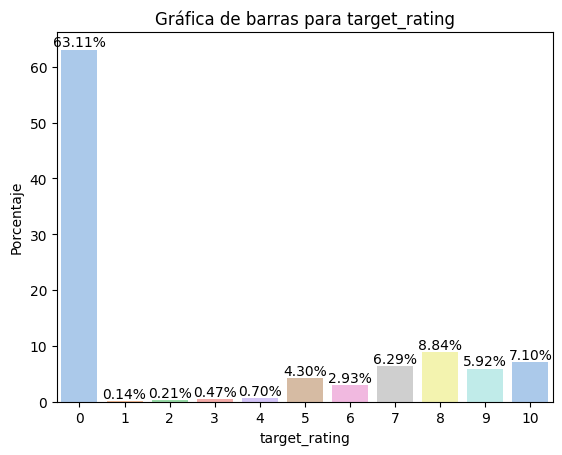

In [150]:
prop = df['target_rating'].value_counts(normalize=True) * 100

ax = sns.barplot(x=prop.index, y=prop.values, palette = palette)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')


plt.xlabel('target_rating')
plt.ylabel('Porcentaje')
plt.title('Gráfica de barras para target_rating')

plt.show()

In [151]:
df = df.loc[df['target_rating']>0]

ahora con los datos actualizados vemos que la calificacion más comun es de 8, en general de las personas que califican, son pocas las que dan una calificacion baja

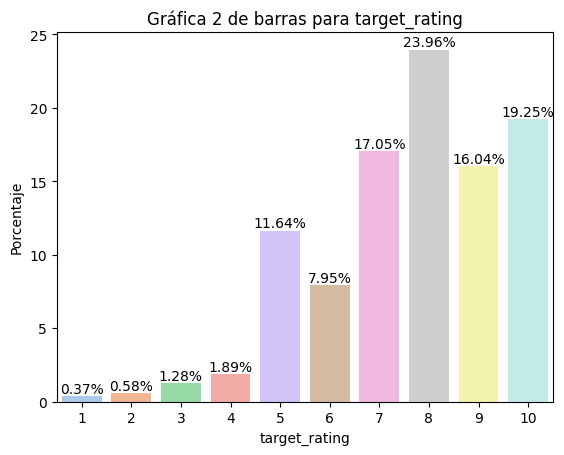

In [152]:
prop = df['target_rating'].value_counts(normalize=True) * 100

ax = sns.barplot(x=prop.index, y=prop.values, palette = palette)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')


plt.xlabel('target_rating')
plt.ylabel('Porcentaje')
plt.title('Gráfica 2 de barras para target_rating')

plt.show()

la siguiente grafica muestra el top de 5 paises que más aparecen en nuestro dataset, observamos que la mayor informacion que tenemos proviene de estados unido 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'usa'),
  Text(1, 0, 'canada'),
  Text(2, 0, 'united kingdom'),
  Text(3, 0, 'australia'),
  Text(4, 0, 'n a'),
  Text(5, 0, 'germany'),
  Text(6, 0, 'portugal'),
  Text(7, 0, 'malaysia'),
  Text(8, 0, 'spain'),
  Text(9, 0, 'new zealand'),
  Text(10, 0, 'netherlands'),
  Text(11, 0, 'Otros'),
  Text(12, 0, 'france'),
  Text(13, 0, 'singapore'),
  Text(14, 0, 'italy')])

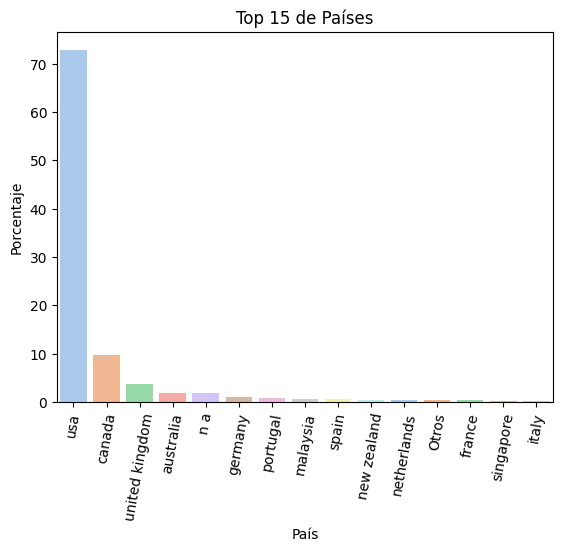

In [153]:
top_paises = df['v_pais'].value_counts().head(15)

# Calcular los porcentajes
prop = (top_paises / len(df['v_pais'])) * 100

# Crear el gráfico de barras
ax = sns.barplot(x=prop.index, y=prop.values, palette="pastel")

# Añadir etiquetas y título
plt.xlabel('País')
plt.ylabel('Porcentaje')
plt.title('Top 15 de Países')

# Rotar las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=80)


la siguiente grafica muestra la proporcion de cada calificacion en cada pais de los top 15, si bien no hay un patron bien definido, si se observa que las calificaciones cambian entre cada pais

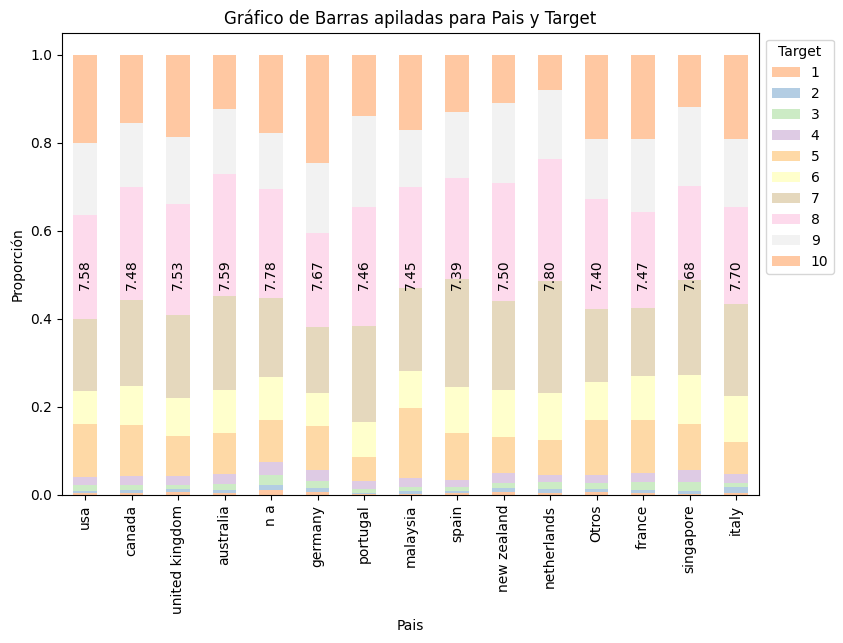

In [155]:
top_categorias = df['v_pais'].value_counts().head(15).index.tolist()

df_filtrado = df[df['v_pais'].isin(top_categorias)]

cross = pd.crosstab(df_filtrado['v_pais'], df_filtrado['target_rating'], normalize='index')
cross = cross.reindex(top_categorias)
colores = ['#ffc8a2', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc', '#e5d8bd', '#fddaec', '#f2f2f2']

ax = cross.plot(kind='bar', stacked=True, figsize=(9, 6), color=colores)
media_por_libro = df_filtrado.groupby('v_pais')['target_rating'].mean()

for i, media in enumerate(media_por_libro):
    ax.annotate(f'{media:.2f}', (i, 0.5), va='center', ha='center', fontsize=10, color='black', rotation='vertical')


plt.xlabel('Pais')
plt.ylabel('Proporción')
plt.title('Gráfico de Barras apiladas para Pais y Target')
ax.legend(title='Target', loc='upper left', bbox_to_anchor=(1, 1))


plt.show()

para los estados observamos que el top de los 15 estados que más aparecen pertenecen a estados unidos

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'california'),
  Text(1, 0, 'ontario'),
  Text(2, 0, 'texas'),
  Text(3, 0, 'new york'),
  Text(4, 0, 'georgia'),
  Text(5, 0, 'florida'),
  Text(6, 0, 'illinois'),
  Text(7, 0, 'washington'),
  Text(8, 0, 'pennsylvania'),
  Text(9, 0, 'n a'),
  Text(10, 0, 'missouri'),
  Text(11, 0, 'ohio'),
  Text(12, 0, 'england'),
  Text(13, 0, 'virginia'),
  Text(14, 0, 'oregon')])

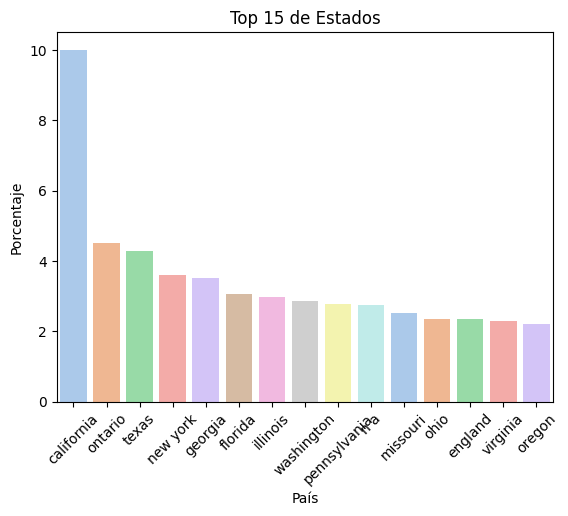

In [156]:
top_paises = df['v_estado'].value_counts().head(15)

prop = (top_paises / len(df['v_estado'])) * 100

# Crear el gráfico de barras
ax = sns.barplot(x=prop.index, y=prop.values, palette="pastel")

# Añadir etiquetas y título
plt.xlabel('País')
plt.ylabel('Porcentaje')
plt.title('Top 15 de Estados')

# Rotar las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45)


para el estado es el mismo caso que pais, si hay diferencias entre cada estado

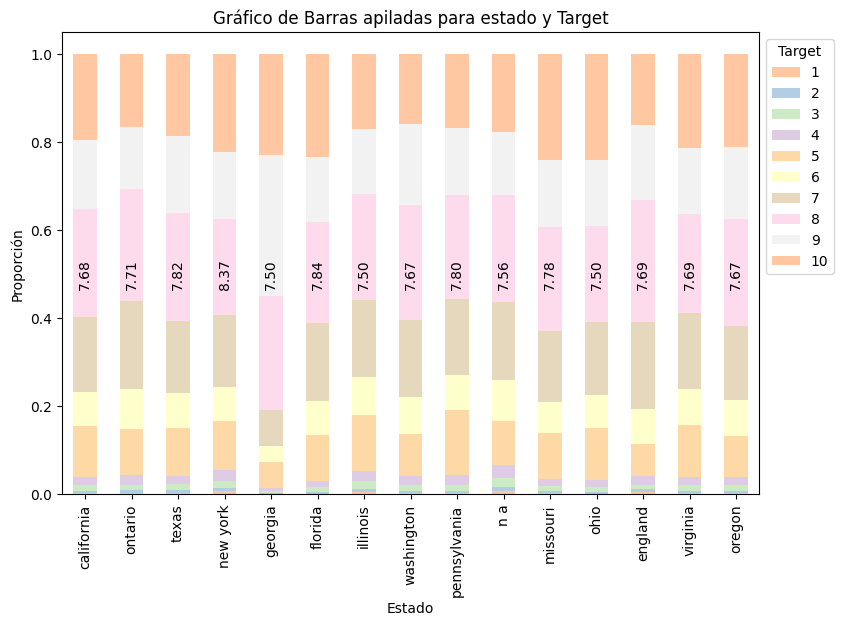

In [157]:
top_categorias = df['v_estado'].value_counts().head(15).index.tolist()

df_filtrado = df[df['v_estado'].isin(top_categorias)]

cross = pd.crosstab(df_filtrado['v_estado'], df_filtrado['target_rating'], normalize='index')
cross = cross.reindex(top_categorias)
colores = ['#ffc8a2', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc', '#e5d8bd', '#fddaec', '#f2f2f2']

ax = cross.plot(kind='bar', stacked=True, figsize=(9, 6), color=colores)
media_por_libro = df_filtrado.groupby('v_estado')['target_rating'].mean()

for i, media in enumerate(media_por_libro):
    ax.annotate(f'{media:.2f}', (i, 0.5), va='center', ha='center', fontsize=10, color='black', rotation='vertical')


plt.xlabel('Estado')
plt.ylabel('Proporción')
plt.title('Gráfico de Barras apiladas para estado y Target')
ax.legend(title='Target', loc='upper left', bbox_to_anchor=(1, 1))


plt.show()

la siguiente gráfica muestra el top 15 de las edidtoriales con más apariciones en nuestro dataset

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'ballantine books'),
  Text(1, 0, 'warner books'),
  Text(2, 0, 'pocket'),
  Text(3, 0, 'berkley publishing group'),
  Text(4, 0, 'Otros'),
  Text(5, 0, 'penguin books'),
  Text(6, 0, 'bantam'),
  Text(7, 0, 'bantam books'),
  Text(8, 0, 'signet book'),
  Text(9, 0, 'perennial'),
  Text(10, 0, 'avon'),
  Text(11, 0, 'harlequin'),
  Text(12, 0, 'dell'),
  Text(13, 0, 'vintage books usa'),
  Text(14, 0, 'scholastic')])

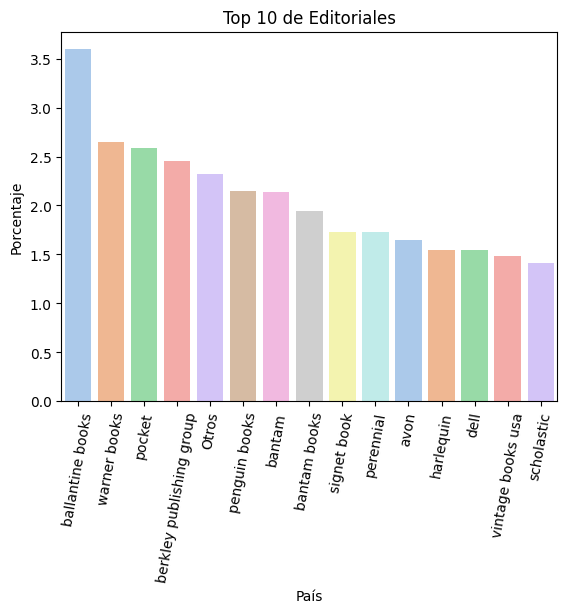

In [158]:
top_paises = df['v_publisher'].value_counts().head(15)

prop = (top_paises / len(df['v_publisher'])) * 100

ax = sns.barplot(x=prop.index, y=prop.values, palette="pastel")

plt.xlabel('País')
plt.ylabel('Porcentaje')
plt.title('Top 10 de Editoriales')

plt.xticks(rotation=80)

para la editorial tambien hay diferencias entre como se distribuye la target para el top de las 15 editoriales

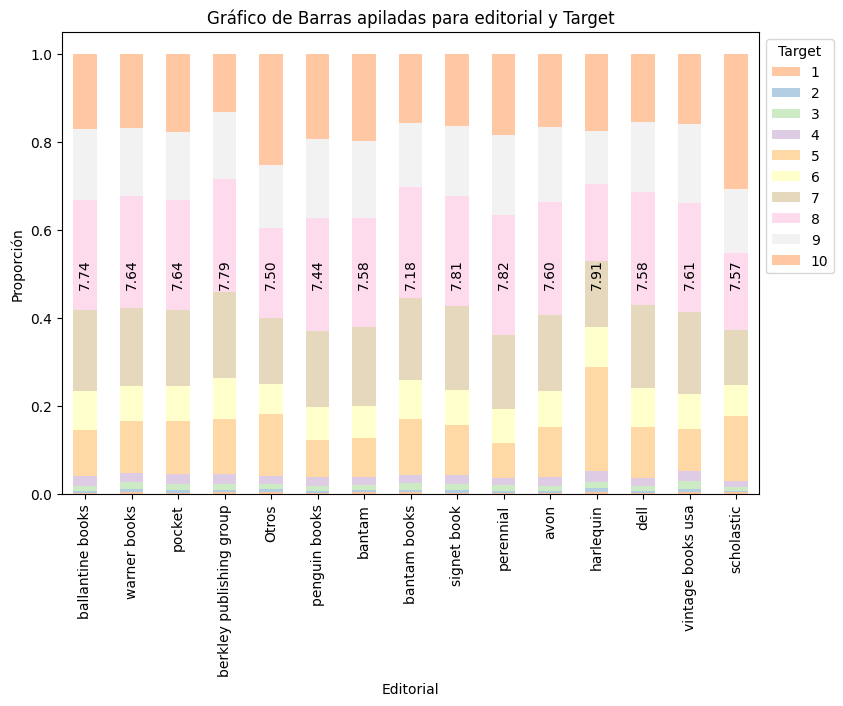

In [159]:
top_categorias = df['v_publisher'].value_counts().head(15).index.tolist()

df_filtrado = df[df['v_publisher'].isin(top_categorias)]

cross = pd.crosstab(df_filtrado['v_publisher'], df_filtrado['target_rating'], normalize='index')
cross = cross.reindex(top_categorias)
colores = ['#ffc8a2', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc', '#e5d8bd', '#fddaec', '#f2f2f2']

ax = cross.plot(kind='bar', stacked=True, figsize=(9, 6), color=colores)
media_por_libro = df_filtrado.groupby('v_publisher')['target_rating'].mean()

for i, media in enumerate(media_por_libro):
    ax.annotate(f'{media:.2f}', (i, 0.5), va='center', ha='center', fontsize=10, color='black', rotation='vertical')


plt.xlabel('Editorial')
plt.ylabel('Proporción')
plt.title('Gráfico de Barras apiladas para editorial y Target')
ax.legend(title='Target', loc='upper left', bbox_to_anchor=(1, 1))


plt.show()

la siguiente grafica muestra el top 10 de autores

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'john grisham'),
  Text(1, 0, 'stephen king'),
  Text(2, 0, 'nora roberts'),
  Text(3, 0, 'j k rowling'),
  Text(4, 0, 'james patterson'),
  Text(5, 0, 'anne rice'),
  Text(6, 0, 'j r r tolkien'),
  Text(7, 0, 'nicholas sparks'),
  Text(8, 0, 'janet evanovich'),
  Text(9, 0, 'sue grafton'),
  Text(10, 0, 'tom clancy'),
  Text(11, 0, 'mary higgins clark'),
  Text(12, 0, 'anita shreve'),
  Text(13, 0, 'dean r koontz'),
  Text(14, 0, 'jack canfield')])

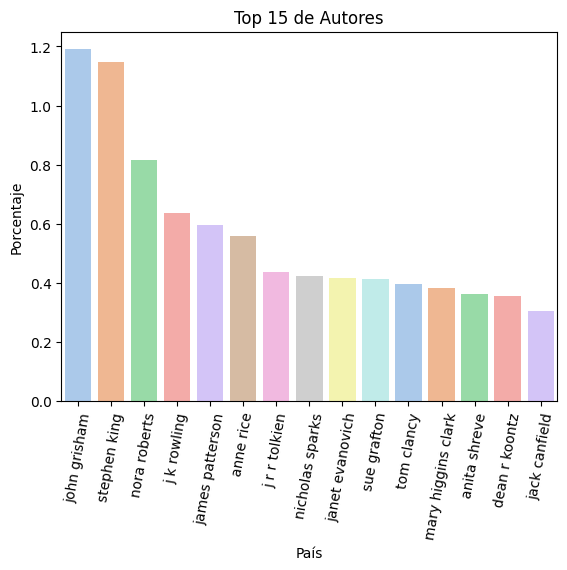

In [165]:
top_paises = df['t_book_author'].value_counts().head(15)

prop = (top_paises / len(df['t_book_author'])) * 100

ax = sns.barplot(x=prop.index, y=prop.values, palette="pastel")

plt.xlabel('País')
plt.ylabel('Porcentaje')
plt.title('Top 15 de Autores')

plt.xticks(rotation=80)

para los autores la diferencia se ve mejor, por ejemplo para j r r tolkien se ve casi el 50% con calidicacion de 10

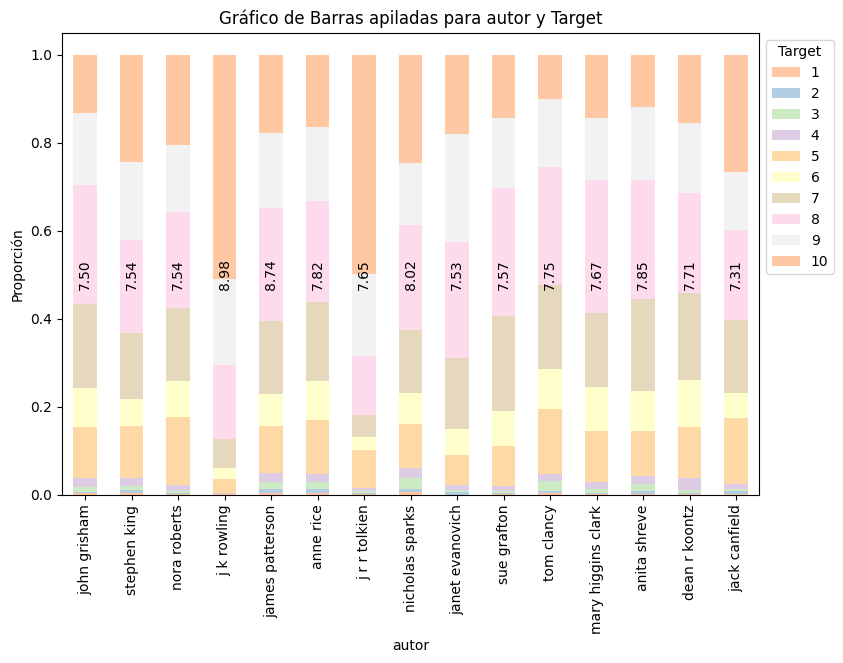

In [166]:
top_categorias = df['t_book_author'].value_counts().head(15).index.tolist()

df_filtrado = df[df['t_book_author'].isin(top_categorias)]

cross = pd.crosstab(df_filtrado['t_book_author'], df_filtrado['target_rating'], normalize='index')
cross = cross.reindex(top_categorias)
colores = ['#ffc8a2', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc', '#e5d8bd', '#fddaec', '#f2f2f2']

ax = cross.plot(kind='bar', stacked=True, figsize=(9, 6), color=colores)
media_por_libro = df_filtrado.groupby('t_book_author')['target_rating'].mean()

for i, media in enumerate(media_por_libro):
    ax.annotate(f'{media:.2f}', (i, 0.5), va='center', ha='center', fontsize=10, color='black', rotation='vertical')


plt.xlabel('autor')
plt.ylabel('Proporción')
plt.title('Gráfico de Barras apiladas para autor y Target')
ax.legend(title='Target', loc='upper left', bbox_to_anchor=(1, 1))


plt.show()

en la siguiente grafica se muestra el top de los libros más aparecidos

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'lovely bones novel'),
  Text(1, 0, 'wild animus'),
  Text(2, 0, 'divine secrets ya ya sisterhood novel'),
  Text(3, 0, 'secret life bees'),
  Text(4, 0, 'nanny diaries novel'),
  Text(5, 0, 'red tent bestselling backlist'),
  Text(6, 0, 'painted house'),
  Text(7, 0, 'life pi'),
  Text(8, 0, 'girl pearl earring'),
  Text(9, 0, 'harry potter chamber secrets book 2'),
  Text(10, 0, 'harry potter sorcerer stone harry potter paperback'),
  Text(11, 0, 'summons'),
  Text(12, 0, 'heart oprah book club paperback'),
  Text(13, 0, 'notebook'),
  Text(14, 0, 'catcher rye')])

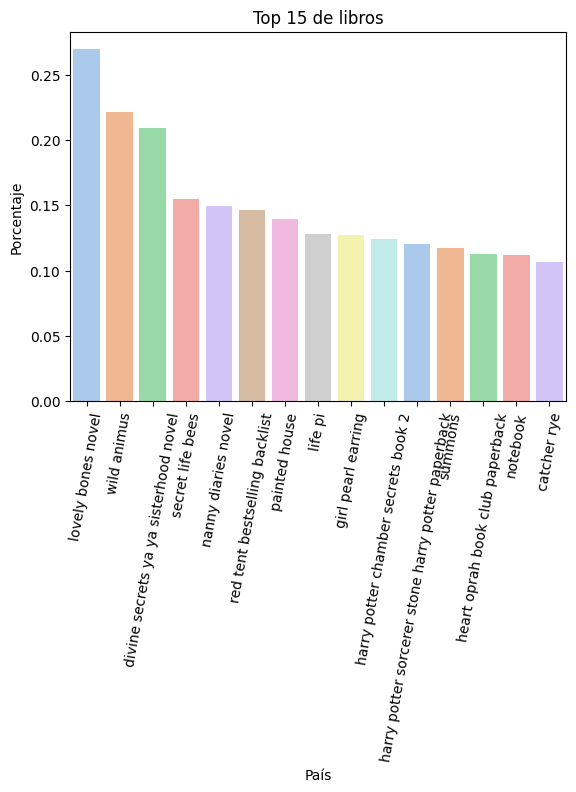

In [167]:
top_paises = df['t_book_title'].value_counts().head(15)

prop = (top_paises / len(df['t_book_title'])) * 100

ax = sns.barplot(x=prop.index, y=prop.values, palette="pastel")

plt.xlabel('País')
plt.ylabel('Porcentaje')
plt.title('Top 15 de libros')

plt.xticks(rotation=80)

para el titulo de los libros la diferencia es más notable, por ejemplo wild animus a pesar de que es de los mas leidos tiene calificaciones bajas

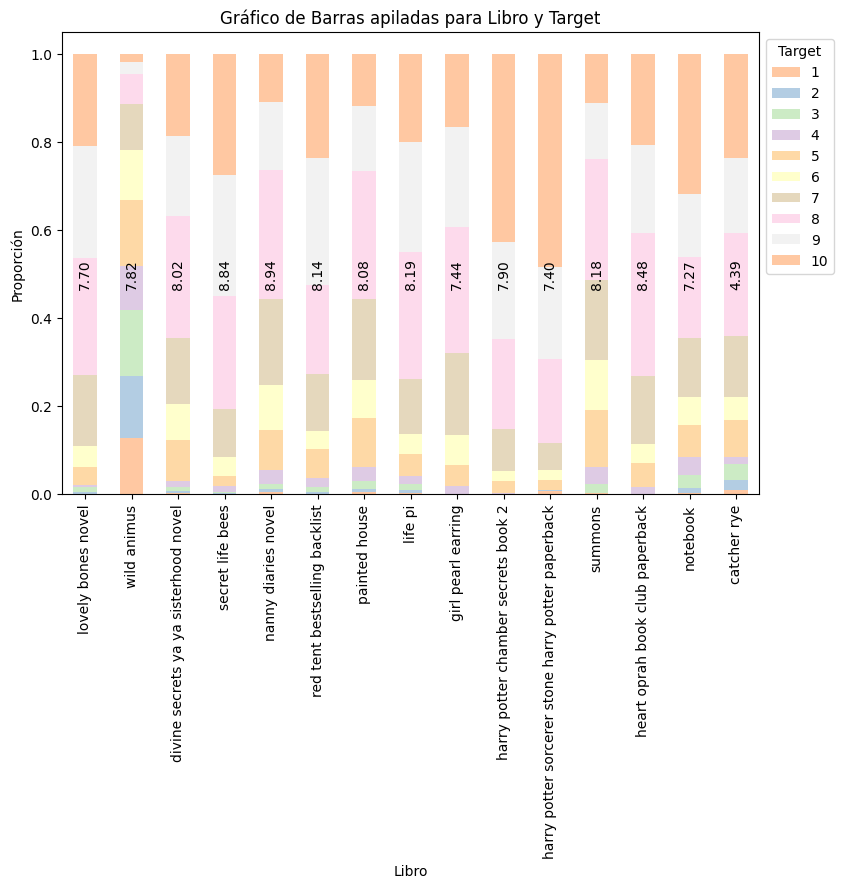

In [168]:
top_categorias = df['t_book_title'].value_counts().head(15).index.tolist()

df_filtrado = df[df['t_book_title'].isin(top_categorias)]

cross = pd.crosstab(df_filtrado['t_book_title'], df_filtrado['target_rating'], normalize='index')
cross = cross.reindex(top_categorias)
colores = ['#ffc8a2', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc', '#e5d8bd', '#fddaec', '#f2f2f2']

ax = cross.plot(kind='bar', stacked=True, figsize=(9, 6), color=colores)
media_por_libro = df_filtrado.groupby('t_book_title')['target_rating'].mean()

for i, media in enumerate(media_por_libro):
    ax.annotate(f'{media:.2f}', (i, 0.5), va='center', ha='center', fontsize=10, color='black', rotation='vertical')


plt.xlabel('Libro')
plt.ylabel('Proporción')
plt.title('Gráfico de Barras apiladas para Libro y Target')
ax.legend(title='Target', loc='upper left', bbox_to_anchor=(1, 1))


plt.show()

para la edad observamos que la mayoria de las personas que contestaron se encuentran entre los 20 y 60 años, de hecho el pico de la distribución se encuentra aproximadamente en los 35 años, se nota un poco de simetria en la derecha en la distribución 

Text(0.5, 1.0, 'Histograma de la edad ')

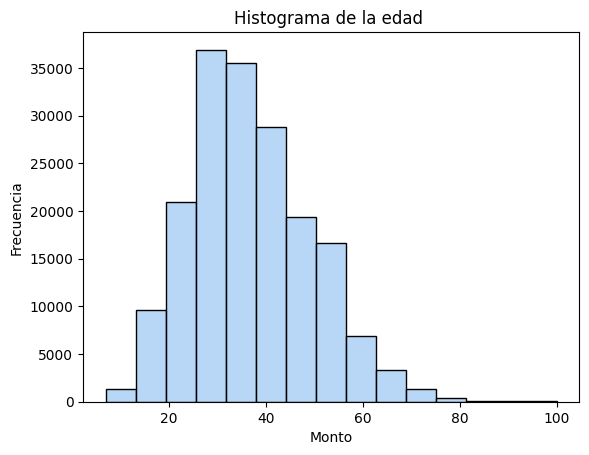

In [169]:
sns.histplot(data=df, x='c_age',bins = 15, color = palette[0])

plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.title('Histograma de la edad ')

In [170]:
df['c_age'].describe()

count    181158.000000
mean         36.839024
std          12.340136
min           7.000000
25%          28.000000
50%          35.000000
75%          46.000000
max         100.000000
Name: c_age, dtype: float64

en la siguiente grafica observamos que la mayor cantidad e registros se encuentran alrededor de los años 2000, lo cual indica que los lectores suelen leer libros más reciente

/tmp/ipykernel_6713/20422180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['c_year_of_publication'] = df2['c_year_of_publication'].astype('int64')


Text(0.5, 1.0, 'Histograma del año de publicacion ')

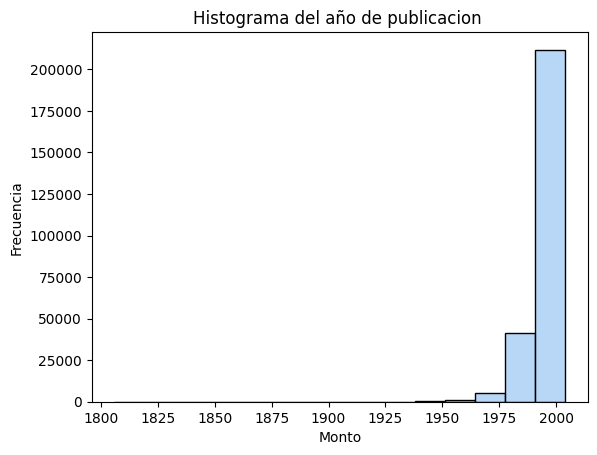

In [171]:
df2 =  df.dropna(subset=['c_year_of_publication'])
df2['c_year_of_publication'] = df2['c_year_of_publication'].astype('int64')
sns.histplot(data=df2, x='c_year_of_publication',bins = 15, color = palette[0])


plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.title('Histograma del año de publicacion ')

el siguiente grafico se aprecia mejor al quitar los posibles datos atipicos

Text(0.5, 1.0, 'Histograma del año de publicacion ')

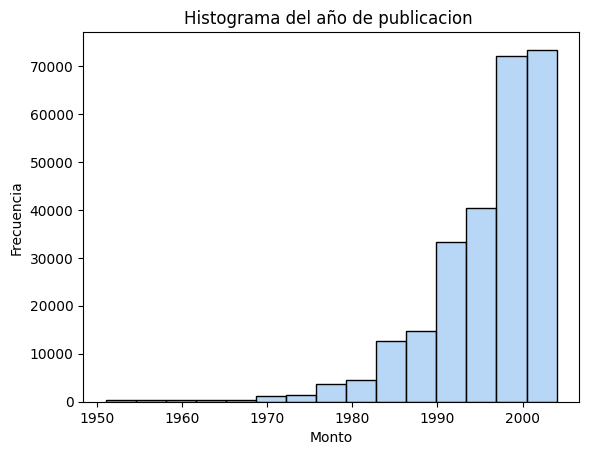

In [172]:

sns.histplot(data=df2.loc[df2['c_year_of_publication'] > 1950], x='c_year_of_publication',bins = 15, color = palette[0])


plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.title('Histograma del año de publicacion ')

In [173]:
df['c_year_of_publication'] = pd.to_numeric(df['c_year_of_publication'], errors='coerce')

/tmp/ipykernel_6713/1402129851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_year_of_publication'] = pd.to_numeric(df['c_year_of_publication'], errors='coerce')


In [174]:
df.dropna(subset=['c_year_of_publication'])

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_estado,v_pais
16,2954,71.0,0060973129,8,decision normandy,carlo d este,1991,harperperennial,kansas,usa
17,152827,40.0,0060973129,7,decision normandy,carlo d este,1991,harperperennial,ontario,canada
19,35704,53.0,0374157065,6,flu story great influenza pandemic 1918 search virus caused,gina bari kolata,1999,farrar straus giroux,missouri,usa
21,110912,36.0,0374157065,10,flu story great influenza pandemic 1918 search virus caused,gina bari kolata,1999,farrar straus giroux,california,usa
23,157969,30.0,0374157065,8,flu story great influenza pandemic 1918 search virus caused,gina bari kolata,1999,farrar straus giroux,colorado,usa
...,...,...,...,...,...,...,...,...,...,...
1031109,278648,NaN,0449225208,5,christmas spirit,patricia wynn,1996,ivy books,nevada,usa
1031110,278659,33.0,0345330293,10,town like alice,nevil shute,1981,ballantine books,washington,usa
1031112,278713,63.0,0670528951,8,orson welles,barbara leaming,1985,penguin usa,new mexico,usa
1031124,278843,28.0,0743525493,7,motley fool money ten steps staying market motley fool,david gardner,2002,simon amp schuster audio,california,usa


In [175]:
df 

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_estado,v_pais
16,2954,71.0,0060973129,8,decision normandy,carlo d este,1991,harperperennial,kansas,usa
17,152827,40.0,0060973129,7,decision normandy,carlo d este,1991,harperperennial,ontario,canada
19,35704,53.0,0374157065,6,flu story great influenza pandemic 1918 search virus caused,gina bari kolata,1999,farrar straus giroux,missouri,usa
21,110912,36.0,0374157065,10,flu story great influenza pandemic 1918 search virus caused,gina bari kolata,1999,farrar straus giroux,california,usa
23,157969,30.0,0374157065,8,flu story great influenza pandemic 1918 search virus caused,gina bari kolata,1999,farrar straus giroux,colorado,usa
...,...,...,...,...,...,...,...,...,...,...
1031109,278648,NaN,0449225208,5,christmas spirit,patricia wynn,1996,ivy books,nevada,usa
1031110,278659,33.0,0345330293,10,town like alice,nevil shute,1981,ballantine books,washington,usa
1031112,278713,63.0,0670528951,8,orson welles,barbara leaming,1985,penguin usa,new mexico,usa
1031124,278843,28.0,0743525493,7,motley fool money ten steps staying market motley fool,david gardner,2002,simon amp schuster audio,california,usa


# datos atipicos 

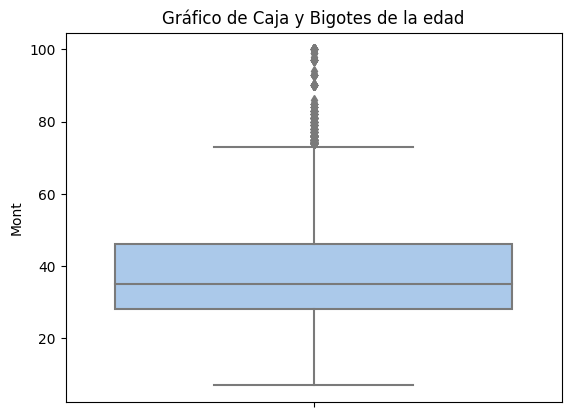

In [176]:
ax = sns.boxplot(y='c_age', data=df,palette=palette)
plt.xlabel('')
plt.ylabel('Mont')
plt.title('Gráfico de Caja y Bigotes de la edad')

plt.show()

para c_age se observa que arriba de 80 hay algunos posible datos atipicos

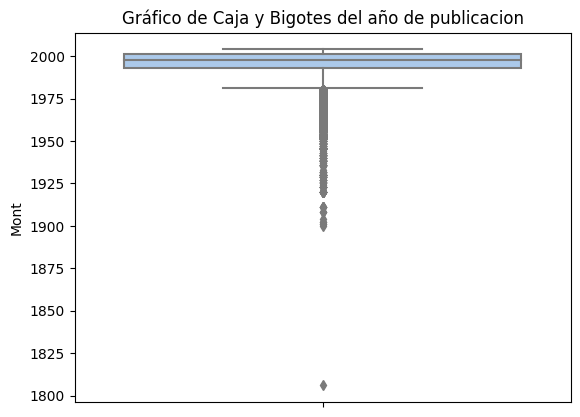

In [177]:
ax = sns.boxplot(y='c_year_of_publication', data=df,palette=palette)
plt.xlabel('')
plt.ylabel('Mont')
plt.title('Gráfico de Caja y Bigotes del año de publicacion')

plt.show()

para el año de publicacion es más evidente los datos atipicos que hay

In [178]:
def aux_outliers(a,b,c):
    a=set(a)
    b=set(b)
    c=set(c)
    a_=a.intersection(b)

    b_=b.intersection(c)

    c_=a.intersection(c)

    outliers_index=list(set(list(a_)+list(b_)+list(c_)))
    return outliers_index
def OUTLIERS(df,cols):
    results=pd.DataFrame()
    data_iqr=df.copy()
    data_per=df.copy()
    total=[]
    total_per=[]
    total_z=[]
    indices_=[]

    for col in cols:
        #IQR
        Q1=df[col].quantile(0.25)
        Q3=df[col].quantile(0.75)
        IQR=Q3-Q1
        INF=Q1-1.5*(IQR)
        SUP=Q3+1.5*(IQR)
    
        
        n_outliers=df[(df[col] < INF) | (df[col] > SUP)].shape[0]
        total.append(n_outliers)
        indices_iqr=list(df[(df[col] < INF) | (df[col] > SUP)].index)        
        #Percentiles
        INF_pe=np.percentile(df[col].dropna(),5)
    
        SUP_pe=np.percentile(df[col].dropna(),95)
        n_outliers_per=df[(df[col] < INF_pe) | (df[col] > SUP_pe)].shape[0]
        total_per.append(n_outliers_per)
        indices_per=list(df[(df[col] < INF_pe) | (df[col] > SUP_pe)].index)
        
        #MEAN CHANGE
        
        perc_100 = [x / 100 for x in range(100)]
        dist = df[col].describe(perc_100).iloc[4:]
        change_dist = df[col].describe(perc_100).iloc[4:].diff()
        mean_change = df[col].describe(
            perc_100).iloc[4:].diff().mean()
        if change_dist["max"] > mean_change:
            ub = dist["max"] - mean_change
            if ub < dist["99%"]:
                ub = dist["99%"]
        else:
            ub = dist["max"]

        if change_dist["1%"] > mean_change:
            lb = dist["0%"] + mean_change
            if lb > dist["1%"]:
                lb = dist["1%"]
        else:
            lb = dist["0%"]
        n_total_z=df[(df[col] < lb) | (df[col] > ub)].shape[0]
        total_z.append(n_total_z)
        indices_z=list(df[(df[col] < lb) | (df[col] > ub)].index)
        
        indices_.append(aux_outliers(indices_iqr,indices_per,indices_z))
        
    results["features"]=cols
    results["n_outliers_IQR"]=total
    results["n_outliers_Percentil"]=total_per
    results["n_outliers_Mean_Change"]=total_z
    results["n_outliers_IQR_%"]=round((results["n_outliers_IQR"]/df.shape[0])*100,2)
    results["n_outliers_Percentil_%"]=round((results["n_outliers_Percentil"]/df.shape[0])*100,2)
    results["n_outliers_Mean_Change_%"]=round((results["n_outliers_Mean_Change"]/df.shape[0])*100,2)
    results["indices"]=indices_
    results["total_outliers"]=results["indices"].map(lambda x:len(x))
    results["%_outliers"]=results["indices"].map(lambda x:round(((len(x)/df.shape[0])*100),2))
    results=results[['features', 'n_outliers_IQR', 'n_outliers_Percentil',
       'n_outliers_Mean_Change', 'n_outliers_IQR_%', 'n_outliers_Percentil_%',
       'n_outliers_Mean_Change_%',  'total_outliers', '%_outliers','indices']]
    return results

vamos a aplicar IQR, Percentiles y MEAN CHANGE para detectar  datos atipicos, aquellos registros donde más de un metodo clasifique a un registro como atipico lo vamos a considerar como atipico 

In [179]:
outliers=OUTLIERS(df,['c_year_of_publication','c_age'])

In [180]:

pd.set_option('display.max_colwidth', 50)

In [181]:
outliers

,features,n_outliers_IQR,n_outliers_Percentil,n_outliers_Mean_Change,n_outliers_IQR_%,n_outliers_Percentil_%,n_outliers_Mean_Change_%,total_outliers,%_outliers,indices
0,c_year_of_publication,9561,19974,1,3.64,7.61,0.00,9561,3.64,"[688137, 983051, 884773, 1015846, 917558, 9175..."
1,c_age,798,15424,68,0.30,5.88,0.03,830,0.32,"[925700, 108551, 354313, 999434, 999433, 56526..."


de c_year_of_publication vamos a eliminar 9561 y de total_outliers vamos a eliminar 830

In [182]:
from  functools import reduce
indices=list(outliers["indices"].values)
indices=list(set(reduce(lambda x,y: x+y, indices)))
len(indices)

10346

In [183]:
len(indices)/df.shape[0]

0.039429555779139605

se eliminaran 10346 que corresponde a cerca de 4% de nuestros datos


In [184]:
df=df[~df.index.isin(indices)].reset_index(drop=True)

In [185]:
df

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,c_year_of_publication,v_publisher,v_estado,v_pais
0,2954,71.0,0060973129,8,decision normandy,carlo d este,1991,harperperennial,kansas,usa
1,152827,40.0,0060973129,7,decision normandy,carlo d este,1991,harperperennial,ontario,canada
2,35704,53.0,0374157065,6,flu story great influenza pandemic 1918 search...,gina bari kolata,1999,farrar straus giroux,missouri,usa
3,110912,36.0,0374157065,10,flu story great influenza pandemic 1918 search...,gina bari kolata,1999,farrar straus giroux,california,usa
4,157969,30.0,0374157065,8,flu story great influenza pandemic 1918 search...,gina bari kolata,1999,farrar straus giroux,colorado,usa
...,...,...,...,...,...,...,...,...,...,...
252041,278648,NaN,0449225208,5,christmas spirit,patricia wynn,1996,ivy books,nevada,usa
252042,278659,33.0,0345330293,10,town like alice,nevil shute,1981,ballantine books,washington,usa
252043,278713,63.0,0670528951,8,orson welles,barbara leaming,1985,penguin usa,new mexico,usa
252044,278843,28.0,0743525493,7,motley fool money ten steps staying market mot...,david gardner,2002,simon amp schuster audio,california,usa


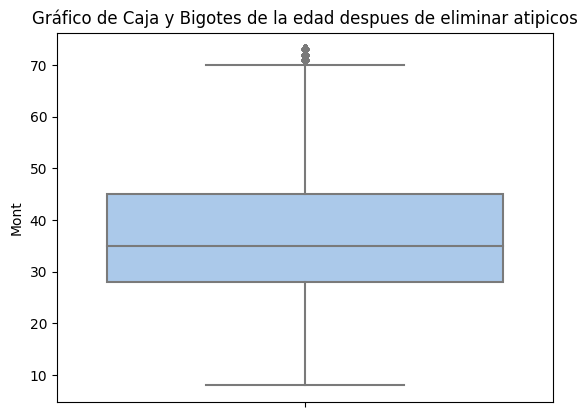

In [186]:
ax = sns.boxplot(y='c_age', data=df,palette=palette)
plt.xlabel('')
plt.ylabel('Mont')
plt.title('Gráfico de Caja y Bigotes de la edad despues de eliminar atipicos')

plt.show()

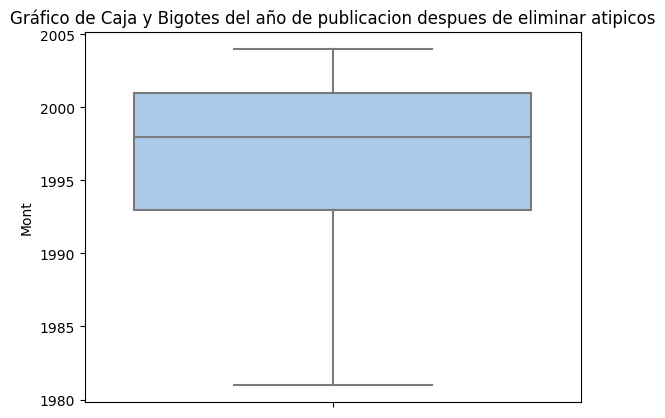

In [187]:
ax = sns.boxplot(y='c_year_of_publication', data=df,palette=palette)
plt.xlabel('')
plt.ylabel('Mont')
plt.title('Gráfico de Caja y Bigotes del año de publicacion despues de eliminar atipicos')

plt.show()

ahora las distribuciones ya se aprecian mejor

# datos faltantes 

In [10]:
df.isnull().mean(axis=0)

NameError: name 'df' is not defined

observamos que la variable c_age tiene más del 30% de datos faltantes, también se observa que las otra variables con datos faltantes son categoricas o de texto, consideramos que para este problema aporta más informacion crear una categoria llamada 'sin informacion' que imputar con la moda (que es el metodo más comun para variables categoricas), para las variables de texto, de igual forma, aporta más informacion especificar que no se tiene informacion a tratar de imputar, en el caso de la variable de edad y año de publicacion se va a reconstruir la variable a categorica y despues se va a aplicar lo mismo que para las otras categoricas, primero generamos nuestra clase que sustituye los null por 'sin informacion', primero dividimos entre conjunto de entrenamiento y test


## Test set y Train set

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test=train_test_split(df,test_size=.3,random_state=13)

NameError: name 'df' is not defined

In [120]:
X_train.shape

(176432, 14)

In [121]:
X_test.shape

(75614, 14)

In [6]:
X_train.isnull().mean(axis=0)

id_user                  0.000000
c_age                    0.311752
id_isbn                  0.000000
target_rating            0.000000
t_book_title             0.000935
t_book_author            0.000006
c_year_of_publication    0.011336
v_publisher              0.000000
v_estado                 0.023624
v_pais                   0.028169
dtype: float64

In [7]:
X_test.isnull().mean(axis=0)

id_user                  0.000000
c_age                    0.309546
id_isbn                  0.000000
target_rating            0.000000
t_book_title             0.001018
t_book_author            0.000000
c_year_of_publication    0.011149
v_publisher              0.000000
v_estado                 0.024202
v_pais                   0.028077
dtype: float64

In [8]:

#with open('x_train1.pkl', 'rb') as file:
#        X_train = pickle.load(file)
#with open('x_test1.pkl', 'rb') as file:
#        X_test   = pickle.load(file)

## variables categoricas y de texto

primero definamos la clase que convierte null en una cadena  'sin informacion'

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        # Este método no hace nada en este caso, pero es necesario para la compatibilidad de Scikit-Learn
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column_name] = X_copy[self.column_name].fillna('sin informacion')
        return X_copy

comenzemos con t_book_title

In [14]:
transformer = CustomTransformer(column_name='t_book_title')
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_train['t_book_title'].value_counts()

t_book_title
lovely bones novel                                                                                            503
divine secrets ya ya sisterhood novel                                                                         388
wild animus                                                                                                   383
secret life bees                                                                                              280
red tent bestselling backlist                                                                                 276
                                                                                                             ... 
really important stuff kids taught                                                                              1
jokers wild wild cards volume 3                                                                                 1
three men boat essential penguin                                           

hacemos lo mismo para las otras variables 

In [15]:
transformer = CustomTransformer(column_name='t_book_author')
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_train['t_book_author'].value_counts()

t_book_author
john grisham                 2189
stephen king                 2108
nora roberts                 1501
j k rowling                  1163
james patterson              1086
                             ... 
brian macarthur                 1
talmadge bickmore deborah       1
rodney hall                     1
richard wurmbrand               1
peter shockey                   1
Name: count, Length: 26150, dtype: int64

In [16]:
transformer = CustomTransformer(column_name='v_estado')
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_train['v_estado'].value_counts()

v_estado
california    17776
ontario        7935
texas          7468
georgia        6427
new york       6323
              ...  
zhejiang          2
d n               2
toapayoh          2
limpopo           1
ribatejo          1
Name: count, Length: 341, dtype: int64

In [17]:
transformer = CustomTransformer(column_name='v_pais')
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_train['v_pais'].value_counts()

v_pais
usa                   128748
canada                 17165
united kingdom          6383
sin informacion         4970
australia               3219
n a                     3113
germany                 1924
portugal                1401
spain                   1071
malaysia                1017
new zealand              845
netherlands              803
Otros                    655
france                   530
singapore                353
italy                    318
philippines              272
switzerland              272
romania                  249
austria                  241
ireland                  226
iran                     224
dominican republic       185
sweden                   163
brazil                   156
finland                  154
japan                    152
england                  150
china                    148
belgium                  133
norway                   127
ohio                     106
poland                    81
mexico                    67
denmark

In [18]:
X_train.isnull().mean(axis=0)

id_user                  0.000000
c_age                    0.311752
id_isbn                  0.000000
target_rating            0.000000
t_book_title             0.000000
t_book_author            0.000000
c_year_of_publication    0.011336
v_publisher              0.000000
v_estado                 0.000000
v_pais                   0.000000
dtype: float64

In [19]:
X_test.isnull().mean(axis=0)

id_user                  0.000000
c_age                    0.309546
id_isbn                  0.000000
target_rating            0.000000
t_book_title             0.000000
t_book_author            0.000000
c_year_of_publication    0.011149
v_publisher              0.000000
v_estado                 0.000000
v_pais                   0.000000
dtype: float64

## variables categoricas 

**variable de edad**

vamos a convertirla a categorica, vamos a crear 4 categorias
* <20
* 20-40
* 40-60
* \>60 

In [20]:
bin_edges = [0, 20, 40, 60, float('inf')]
bin_labels = ['<20', '20-40', '40-60', '>60']

X_train['c_age'] = pd.cut(X_train['c_age'], bins=bin_edges, labels=bin_labels)
X_train['c_age'] = X_train['c_age'].astype('O')
X_test['c_age'] = pd.cut(X_test['c_age'], bins=bin_edges, labels=bin_labels)
X_test['c_age'] = X_test['c_age'].astype('O')
X_train['c_age'].value_counts()

c_age
20-40    70270
40-60    38536
<20       8561
>60       4062
Name: count, dtype: int64

ahora convertirmos lo null  a 'sin informacion'

In [21]:
X_train = X_train.rename(columns={'c_age': 'v_age'})
X_test= X_test.rename(columns={'c_age': 'v_age'})
transformer = CustomTransformer(column_name='v_age')
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_train['v_age'].value_counts()

v_age
20-40              70270
sin informacion    55003
40-60              38536
<20                 8561
>60                 4062
Name: count, dtype: int64

**variable c_year_of_publication**

para esta variable primer vamos a hacer una transformación, considerando que los datos se obtuvieron en el 2004, vamos a calcular la diferencencia entre la recopilacion de datos y el año de publicación, a un modelo ML no es buena idea pasarle una variable de años, ya que en un futuro no sabrá que hacer con los años nuevos (por ejemplo hoy 2023, el modelo nunca recibio ese dato), la antiguiedad del libro en cambio, si es un valor que se puede generalizar

In [12]:
X_train['v_antiguedad_book'] = 2004  - X_train['c_year_of_publication'] 
X_test['v_antiguedad_book'] = 2004  - X_test['c_year_of_publication'] 
X_train = X_train.drop('c_year_of_publication', axis = 1)
X_test = X_test.drop('c_year_of_publication', axis = 1)

In [13]:
X_train

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book
11124,10965,22.0,0441569595,9,neuromancer remembering tomorrow,william gibson,ace books,uppland,sweden,9
160672,269566,9.0,080694756X,8,fantastic book logic puzzles,muriel mandell,sterling publishing,washington,usa,18
251066,265533,NaN,0732710561,8,story amy johnson pioneering woman aviator set...,janet stott thornton,Otros,n a,new zealand,3
215304,93047,52.0,0930193334,8,love amp rockets heartbreak soup,jaime hernandez,fantagraphics books,new hampshire,usa,17
132326,12100,26.0,0803263430,8,book promethea le de promethea european women ...,helene cixous,university of nebraska press,national capital region,philippines,13
...,...,...,...,...,...,...,...,...,...,...
218868,98391,52.0,0451458435,9,dreamer novel silent empire,steven harper,eos,georgia,usa,3
164706,55955,38.0,0840790414,5,listen god,charles stanley,nelson books,Otros,china,19
229450,129716,30.0,0807012238,9,blooming lotus guided meditation exercises hea...,thich nhat hanh,beacon press,florida,usa,7
178352,35921,8.0,0307119726,6,shopping mom golden look look book,mercer mayer,golden books,ohio,usa,6


In [14]:
X_test

,id_user,c_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book
93835,73923,29.0,0060097825,8,zoya story afghan woman struggle freedom,john follain,william morrow,california,usa,2
163275,27135,NaN,0373036736,8,claiming baby ready baby harlequin romance 3673,rebecca winters,harlequin,missouri,usa,3
157546,23902,NaN,0811213188,7,simple heart new directions bibelot,gustave flaubert,new directions publishing corporation,england,united kingdom,8
82543,153662,44.0,0886774616,8,catfantastic ii daw book collectors,andre norton,daw books,georgia,usa,10
3534,144133,38.0,0385337639,7,crow lake today show book club 7,mary lawson,dell,north carolina,usa,1
...,...,...,...,...,...,...,...,...,...,...
194074,54218,27.0,037312144X,7,mother child harlequin presents,sandra field,harlequin,rheinland pfalz,germany,4
200744,225986,36.0,0140347283,8,esio trot puffin books,roald dahl,puffin books,england,united kingdom,13
44341,81249,NaN,1573229326,9,good,nick hornby,riverhead books,ontario,canada,2
113896,209516,57.0,0553574574,10,beach music,pat conroy,bantam books,suffolk,united kingdom,8


/tmp/ipykernel_23752/1052931709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['v_antiguedad_book'] = df2['v_antiguedad_book'].astype('int64')


Text(0.5, 1.0, 'Histograma de la antiguiedad del libro')

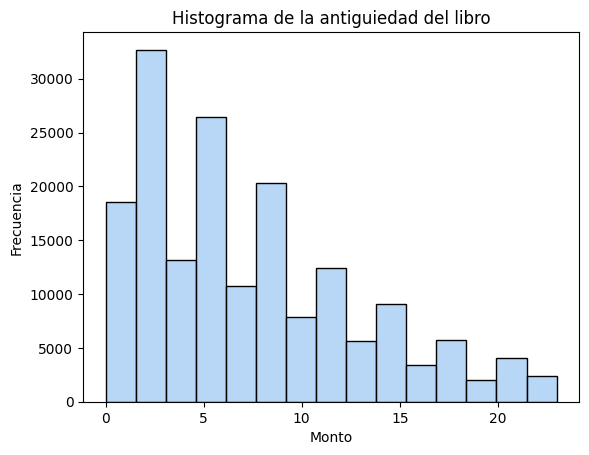

In [15]:
df2 = X_train.loc[~X_train['v_antiguedad_book'].isnull()]
df2['v_antiguedad_book'] = df2['v_antiguedad_book'].astype('int64')
sns.histplot(data=df2, x='v_antiguedad_book',bins = 15, color = palette[0])


plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.title('Histograma de la antiguiedad del libro')

vamos a crear 5 categorias 
* <5
* 5-10
* 10-15
* 15-20
* \>20

In [26]:
bin_edges = [0, 5, 10, 15,20, float('inf')]
bin_labels = ['<5', '5-10', '10-15','15-20', '>20']

X_train['v_antiguedad_book'] = pd.cut(X_train['v_antiguedad_book'], bins=bin_edges, labels=bin_labels)
X_train['v_antiguedad_book'] = X_train['v_antiguedad_book'].astype('O')
X_test['v_antiguedad_book'] = pd.cut(X_test['v_antiguedad_book'], bins=bin_edges, labels=bin_labels)
X_test['v_antiguedad_book'] = X_test['v_antiguedad_book'].astype('O')
X_train['v_antiguedad_book'].value_counts()

v_antiguedad_book
<5       73807
5-10     51038
10-15    27137
15-20    13307
>20       4265
Name: count, dtype: int64

convertimos los null a 'sin informacion'


In [27]:

transformer = CustomTransformer(column_name='v_antiguedad_book')
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_train['v_antiguedad_book'].value_counts()

v_antiguedad_book
<5                 73807
5-10               51038
10-15              27137
15-20              13307
sin informacion     6878
>20                 4265
Name: count, dtype: int64

In [28]:
X_train.isnull().mean(axis=0)

id_user              0.0
v_age                0.0
id_isbn              0.0
target_rating        0.0
t_book_title         0.0
t_book_author        0.0
v_publisher          0.0
v_estado             0.0
v_pais               0.0
v_antiguedad_book    0.0
dtype: float64

In [29]:
X_test.isnull().mean(axis=0)

id_user              0.0
v_age                0.0
id_isbn              0.0
target_rating        0.0
t_book_title         0.0
t_book_author        0.0
v_publisher          0.0
v_estado             0.0
v_pais               0.0
v_antiguedad_book    0.0
dtype: float64

ya tenemos la información sin valores nulos 

# Ingenieria de variables

hasta este punto ya hemos varias cosas correspondientes a ingenieria de variables, como lo es calcular la antiguiedad del libro al momento de recopilarse los datos, convertir variables numericas a categoricas, no se puso en esta seccion ya que era necesario hacerlo antes



primero vamos a tratar con la variable t_book_title, queremos tener una representacion a 3 dimenciones de los datos, vamos a utilizar la  libreria fasttext para convertir cada palabra del nombre del libro a una representacion numerica, para ello vamos a descargar un modelo previamentente entrenado, el modelo lo descargamos de 
https://fasttext.cc/docs/en/english-vectors.html

In [8]:
import fasttext
from gensim.models import KeyedVectors
model_fasttext = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec', binary=False)


la siguiente funcion nos regresa los embeddings de un texto

In [32]:
def get_word_embeddings(text):
    words = text.split()
    embeddings = [model_fasttext.get_vector(word) for word in words if word in model_fasttext.key_to_index]
    return embeddings

calculamos los embedings 

In [47]:
X_train['embbeding_book'] = X_train['t_book_title'].apply(get_word_embeddings)

In [36]:
#with open('X_train2.pkl', 'rb') as file:
#        X_train = pickle.load(file)
#with open('X_test2.pkl', 'rb') as file:
#        X_test   = pickle.load(file)

calculamos el promedio de los embeddings para todos los nombres de los libros

In [37]:
X_train['average_embedding'] = X_train['embbeding_book'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else [0.0] * 300)

reducimos la dimensionalidad a 3

In [38]:
pd.set_option('display.max_colwidth', 50)

In [39]:
X_train

,id_user,v_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book,embbeding_book,average_embedding
11124,10965,20-40,0441569595,9,neuromancer remembering tomorrow,william gibson,ace books,uppland,sweden,5-10,"[[0.0461, 0.0067, -0.2809, -0.0735, -0.1206, -...","[-0.027049998, 0.0634, -0.1781, -0.105399996, ..."
160672,269566,<20,080694756X,8,fantastic book logic puzzles,muriel mandell,sterling publishing,washington,usa,15-20,"[[-0.1046, -0.1119, -0.1056, 0.0329, -0.0008, ...","[-0.08635, -0.062374998, -0.10525, 0.075, 0.01..."
251066,265533,sin informacion,0732710561,8,story amy johnson pioneering woman aviator set...,janet stott thornton,Otros,n a,new zealand,<5,"[[-0.1119, -0.0345, -0.0867, -0.1041, 0.0297, ...","[-0.0137642855, 0.029042857, -0.030064289, 0.0..."
215304,93047,40-60,0930193334,8,love amp rockets heartbreak soup,jaime hernandez,fantagraphics books,new hampshire,usa,15-20,"[[-0.1306, -0.0266, -0.102, -0.1321, -0.0941, ...","[-0.07902, 0.06326, -0.039640002, -0.1066, 0.0..."
132326,12100,20-40,0803263430,8,book promethea le de promethea european women ...,helene cixous,university of nebraska press,national capital region,philippines,10-15,"[[-0.1203, 0.0483, 0.0165, 0.1011, -0.0324, 0....","[-0.03883333, 0.039316665, -0.010683336, 0.090..."
...,...,...,...,...,...,...,...,...,...,...,...,...
218868,98391,40-60,0451458435,9,dreamer novel silent empire,steven harper,eos,georgia,usa,<5,"[[0.1558, -0.119, -0.0314, -0.085, 0.1669, 0.0...","[0.086950004, -0.094375, 0.015800001, -0.01060..."
164706,55955,20-40,0840790414,5,listen god,charles stanley,nelson books,Otros,china,15-20,"[[-0.21, 0.1045, -0.0178, 0.0267, -0.0712, -0....","[-0.067499995, 0.13340001, -0.09375, 0.0579499..."
229450,129716,20-40,0807012238,9,blooming lotus guided meditation exercises hea...,thich nhat hanh,beacon press,florida,usa,5-10,"[[-0.0365, -0.2427, -0.2064, -0.1697, -0.0254,...","[-0.016575001, 0.0771625, -0.0417375, -0.09252..."
178352,35921,<20,0307119726,6,shopping mom golden look look book,mercer mayer,golden books,ohio,usa,5-10,"[[0.1244, -0.205, -0.0649, 0.1264, -0.0954, -0...","[-0.011616669, 0.006350001, 0.017466664, 0.025..."


In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_train['average_embedding'].tolist())
list_emb = list(pca.transform(X_train['average_embedding'].tolist()))

In [41]:

X_train['c_embedding_book1'] = [array[0] for array in list_emb]
X_train['c_embedding_book2'] = [array[1] for array in list_emb]
X_train['c_embedding_book3'] = [array[2] for array in list_emb]

In [42]:
X_train

,id_user,v_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book,embbeding_book,average_embedding,c_embedding_book1,c_embedding_book2,c_embedding_book3
11124,10965,20-40,0441569595,9,neuromancer remembering tomorrow,william gibson,ace books,uppland,sweden,5-10,"[[0.0461, 0.0067, -0.2809, -0.0735, -0.1206, -...","[-0.027049998, 0.0634, -0.1781, -0.105399996, ...",-0.474444,-0.109460,-0.111748
160672,269566,<20,080694756X,8,fantastic book logic puzzles,muriel mandell,sterling publishing,washington,usa,15-20,"[[-0.1046, -0.1119, -0.1056, 0.0329, -0.0008, ...","[-0.08635, -0.062374998, -0.10525, 0.075, 0.01...",-0.086173,0.226579,-0.276379
251066,265533,sin informacion,0732710561,8,story amy johnson pioneering woman aviator set...,janet stott thornton,Otros,n a,new zealand,<5,"[[-0.1119, -0.0345, -0.0867, -0.1041, 0.0297, ...","[-0.0137642855, 0.029042857, -0.030064289, 0.0...",0.033391,0.039985,-0.138966
215304,93047,40-60,0930193334,8,love amp rockets heartbreak soup,jaime hernandez,fantagraphics books,new hampshire,usa,15-20,"[[-0.1306, -0.0266, -0.102, -0.1321, -0.0941, ...","[-0.07902, 0.06326, -0.039640002, -0.1066, 0.0...",0.050648,0.035556,0.116843
132326,12100,20-40,0803263430,8,book promethea le de promethea european women ...,helene cixous,university of nebraska press,national capital region,philippines,10-15,"[[-0.1203, 0.0483, 0.0165, 0.1011, -0.0324, 0....","[-0.03883333, 0.039316665, -0.010683336, 0.090...",0.095870,0.021198,-0.176152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218868,98391,40-60,0451458435,9,dreamer novel silent empire,steven harper,eos,georgia,usa,<5,"[[0.1558, -0.119, -0.0314, -0.085, 0.1669, 0.0...","[0.086950004, -0.094375, 0.015800001, -0.01060...",0.068360,0.254794,-0.065403
164706,55955,20-40,0840790414,5,listen god,charles stanley,nelson books,Otros,china,15-20,"[[-0.21, 0.1045, -0.0178, 0.0267, -0.0712, -0....","[-0.067499995, 0.13340001, -0.09375, 0.0579499...",-0.072695,-0.175971,0.096274
229450,129716,20-40,0807012238,9,blooming lotus guided meditation exercises hea...,thich nhat hanh,beacon press,florida,usa,5-10,"[[-0.0365, -0.2427, -0.2064, -0.1697, -0.0254,...","[-0.016575001, 0.0771625, -0.0417375, -0.09252...",-0.105845,0.027021,0.100677
178352,35921,<20,0307119726,6,shopping mom golden look look book,mercer mayer,golden books,ohio,usa,5-10,"[[0.1244, -0.205, -0.0649, 0.1264, -0.0954, -0...","[-0.011616669, 0.006350001, 0.017466664, 0.025...",-0.123810,-0.106555,-0.044498


In [67]:
X_train = X_train.drop(['embbeding_book','average_embedding'], axis =1)

hacemos lo mismo para test 

In [43]:
X_test['embbeding_book'] = X_test['t_book_title'].apply(get_word_embeddings)

NameError: name 'get_word_embeddings' is not defined

In [44]:

X_test['average_embedding'] = X_test['embbeding_book'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else [0.0] * 300)
list_emb = list(pca.transform(X_test['average_embedding'].tolist()))
X_test['c_embedding_book1'] = [array[0] for array in list_emb]
X_test['c_embedding_book2'] = [array[1] for array in list_emb]
X_test['c_embedding_book3'] = [array[2] for array in list_emb]
X_test = X_test.drop(['embbeding_book','average_embedding'], axis =1)
X_test

,id_user,v_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book,c_embedding_book1,c_embedding_book2,c_embedding_book3
93835,73923,20-40,0060097825,8,zoya story afghan woman struggle freedom,john follain,william morrow,california,usa,<5,0.078748,0.150277,-0.019643
163275,27135,sin informacion,0373036736,8,claiming baby ready baby harlequin romance 3673,rebecca winters,harlequin,missouri,usa,<5,0.009767,-0.108935,0.037026
157546,23902,sin informacion,0811213188,7,simple heart new directions bibelot,gustave flaubert,new directions publishing corporation,england,united kingdom,5-10,-0.378020,-0.058630,-0.071167
82543,153662,40-60,0886774616,8,catfantastic ii daw book collectors,andre norton,daw books,georgia,usa,5-10,0.171166,-0.045367,-0.229393
3534,144133,20-40,0385337639,7,crow lake today show book club 7,mary lawson,dell,north carolina,usa,<5,-0.048435,-0.003475,0.022837
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194074,54218,20-40,037312144X,7,mother child harlequin presents,sandra field,harlequin,rheinland pfalz,germany,<5,0.061625,-0.006903,0.045413
200744,225986,20-40,0140347283,8,esio trot puffin books,roald dahl,puffin books,england,united kingdom,10-15,0.273519,-0.028958,-0.044024
44341,81249,sin informacion,1573229326,9,good,nick hornby,riverhead books,ontario,canada,<5,-0.492708,-0.487032,-0.261678
113896,209516,40-60,0553574574,10,beach music,pat conroy,bantam books,suffolk,united kingdom,5-10,0.159571,0.155238,0.197419


**t_book_author**


para t_book_author queremos promediar los embedding de todos los libros que ha escrito, por ejemplo si william gibson	 ha escrito 1000 libros, queremos promediar esos 1000 registros en c_embedding_book1, c_embedding_book2,c_embedding_book3 para obtener una represanticióm 3D

In [45]:
promedios_por_autor = X_train.groupby('t_book_author')[['c_embedding_book1', 'c_embedding_book2', 'c_embedding_book3']].mean()
promedios_por_autor.columns = ['c_embedding_autor1', 'c_embedding_autor2', 'c_embedding_autor3']


In [46]:
X_train = X_train.merge(promedios_por_autor, left_on='t_book_author', right_index=True, how='inner')
X_train 

,id_user,v_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book,embbeding_book,average_embedding,c_embedding_book1,c_embedding_book2,c_embedding_book3,c_embedding_autor1,c_embedding_autor2,c_embedding_autor3
11124,10965,20-40,0441569595,9,neuromancer remembering tomorrow,william gibson,ace books,uppland,sweden,5-10,"[[0.0461, 0.0067, -0.2809, -0.0735, -0.1206, -...","[-0.027049998, 0.0634, -0.1781, -0.105399996, ...",-0.474444,-0.109460,-0.111748,-0.249805,-0.038410,-0.068054
11178,185677,sin informacion,0441569595,8,neuromancer remembering tomorrow,william gibson,ace books,florida,usa,5-10,"[[0.0461, 0.0067, -0.2809, -0.0735, -0.1206, -...","[-0.027049998, 0.0634, -0.1781, -0.105399996, ...",-0.474444,-0.109460,-0.111748,-0.249805,-0.038410,-0.068054
11156,115435,20-40,0441569595,9,neuromancer remembering tomorrow,william gibson,ace books,ohio,usa,5-10,"[[0.0461, 0.0067, -0.2809, -0.0735, -0.1206, -...","[-0.027049998, 0.0634, -0.1781, -0.105399996, ...",-0.474444,-0.109460,-0.111748,-0.249805,-0.038410,-0.068054
110984,225595,20-40,0441089348,10,burning chrome ace science fiction,william gibson,ace books,georgia,usa,5-10,"[[-0.0631, -0.1674, -0.0042, -0.0675, -0.0361,...","[-0.04598, -0.039440002, -0.0155, -0.074200004...",0.080368,0.093044,-0.011725,-0.249805,-0.038410,-0.068054
78399,5963,20-40,0399145796,8,tomorrow parties,william gibson,putnam pub group,california,usa,<5,"[[-0.1002, 0.1201, -0.0753, -0.1373, -0.0287, ...","[-0.0506, 0.08505, 0.01345, -0.1367, -0.030299...",-0.292649,0.021032,0.021446,-0.249805,-0.038410,-0.068054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251414,269566,<20,0590462377,5,tree cranes,allen say,scholastic inc,washington,usa,sin informacion,"[[0.0477, 0.0345, -0.0819, -0.0237, -0.1262, -...","[-0.0652, 0.18055, -0.0814, -0.08385, -0.1053,...",0.280838,0.027674,0.458533,0.280838,0.027674,0.458533
248466,239551,20-40,0749902698,4,surgeon,francis roe,judy piatkus publishers ltd,england,united kingdom,5-10,"[[0.0347, -0.0711, 0.0652, -0.1504, -0.0558, 0...","[0.0347, -0.0711, 0.0652, -0.1504, -0.0558, 0....",0.333995,0.295519,0.186658,0.333995,0.295519,0.186658
245206,210035,20-40,0449214524,8,naughty lady ness,claudette williams,fawcett books,maryland,usa,15-20,"[[0.0135, -0.2552, -0.1945, -0.1225, -0.0335, ...","[0.032733332, -0.107533336, -0.12913333, 0.026...",0.174695,-0.192299,0.054571,0.174695,-0.192299,0.054571
182501,38556,sin informacion,0933031386,5,hazard losers brown bag mystery series,lloyd biggle,council oak distribution,alberta,canada,10-15,"[[0.0506, -0.0358, -0.2096, -0.031, -0.023, 0....","[0.019416668, -0.0048499997, -0.10285, 0.08931...",-0.081624,0.109264,0.110893,-0.081624,0.109264,0.110893


In [47]:
X_test = X_test.merge(promedios_por_autor, left_on='t_book_author', right_index=True, how='inner')
X_test

,id_user,v_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book,c_embedding_book1,c_embedding_book2,c_embedding_book3,c_embedding_autor1,c_embedding_autor2,c_embedding_autor3
93835,73923,20-40,0060097825,8,zoya story afghan woman struggle freedom,john follain,william morrow,california,usa,<5,0.078748,0.150277,-0.019643,0.078748,0.150277,-0.019643
93834,57255,sin informacion,0060097825,8,zoya story afghan woman struggle freedom,john follain,william morrow,tennessee,usa,<5,0.078748,0.150277,-0.019643,0.078748,0.150277,-0.019643
163275,27135,sin informacion,0373036736,8,claiming baby ready baby harlequin romance 3673,rebecca winters,harlequin,missouri,usa,<5,0.009767,-0.108935,0.037026,0.072318,-0.027377,0.026805
153728,257700,20-40,0373711336,5,home copper mountain,rebecca winters,harlequin,pennsylvania,usa,<5,-0.046802,0.041325,0.338242,0.072318,-0.027377,0.026805
148944,156467,20-40,0373709811,10,accidentally count cop harlequin superromance 981,rebecca winters,harlequin,massachusetts,usa,<5,0.020929,-0.143912,-0.050193,0.072318,-0.027377,0.026805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245661,213535,20-40,0767900766,5,emperor general,james h webb,bantam dell pub group,connecticut,usa,<5,-0.010206,0.013867,-0.013442,-0.069570,0.112594,0.096482
214266,90471,20-40,0449910210,7,jane brody good seafood book,jane e brody,ballantine books,california,usa,5-10,0.255679,-0.230483,-0.240118,0.018740,-0.158111,-0.147061
191926,104604,20-40,0802130550,8,introduction zen buddhism,d t suzuki,grove atlantic,dc,canada,10-15,0.293324,-0.091890,-0.260544,0.293324,-0.091890,-0.260544
225173,113955,<20,0439049946,8,journal sean sullivan transcontinental railroa...,william durbin,scholastic,new york,usa,<5,0.296790,-0.206806,-0.116875,0.299990,-0.236195,0.000135


**v_estado**

para el estado calculamos el promedio de target_rating por estado y agregamos la columna c_mean_rate_estado con esta informacion

In [48]:
promedios_por_estado = X_train.groupby('v_estado')[['target_rating']].mean()
promedios_por_estado.columns = ['c_mean_rate_estado']
promedios_por_estado

,c_mean_rate_estado
v_estado,
Otros,7.454899
aberdeenshire,8.000000
acworth,6.200000
alabama,7.604054
alaska,7.372263
...,...
zeeland,8.571429
zh,5.875000
zhejiang,9.000000


In [49]:
X_train = X_train.merge(promedios_por_estado, left_on='v_estado', right_index=True, how='inner')
X_train

,id_user,v_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book,embbeding_book,average_embedding,c_embedding_book1,c_embedding_book2,c_embedding_book3,c_embedding_autor1,c_embedding_autor2,c_embedding_autor3,c_mean_rate_estado
11124,10965,20-40,0441569595,9,neuromancer remembering tomorrow,william gibson,ace books,uppland,sweden,5-10,"[[0.0461, 0.0067, -0.2809, -0.0735, -0.1206, -...","[-0.027049998, 0.0634, -0.1781, -0.105399996, ...",-0.474444,-0.109460,-0.111748,-0.249805,-0.038410,-0.068054,8.083333
28187,74571,sin informacion,0140620338,9,picture dorian gray,oscar wilde,penguin putnam mass,uppland,sweden,sin informacion,"[[-0.0401, -0.0253, -0.073, -0.0817, -0.0457, ...","[-0.10943333, 0.06763334, -0.0217, 0.014600002...",0.115996,-0.222205,0.097081,0.123137,-0.060670,-0.045662,8.083333
132579,74571,sin informacion,0140621377,9,happy prince stories penguin popular classics,oscar wilde,penguin books ltd,uppland,sweden,5-10,"[[-0.1289, -0.0841, -0.1225, -0.2491, 0.1207, ...","[-0.09601667, 0.0024833356, -0.04671667, -0.07...",0.118882,0.083297,-0.076255,0.123137,-0.060670,-0.045662,8.083333
84071,70585,40-60,1400031346,7,1 ladies detective agency,alexander mccall smith,anchor uk,uppland,sweden,<5,"[[0.0377, 0.0138, 0.0532, 0.0555, 0.0615, 0.12...","[0.0193, -0.083275005, 0.002199999, -0.0108999...",0.078251,0.107035,-0.063878,0.010684,0.076874,-0.051541,8.083333
204654,176408,sin informacion,0440295572,8,legacy silence,belva plain,dell publishing company,uppland,sweden,<5,"[[0.1555, -0.0042, 0.0088, -0.1399, -0.0074, 0...","[0.092999995, 0.078200005, 0.0248, -0.1127, -0...",-0.341716,0.181584,0.067081,-0.035896,0.141078,0.176387,8.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167837,30144,sin informacion,0767906284,6,hunt zero point inside classified world antigr...,nick cook,broadway,armed forces europe,usa,<5,"[[0.0269, 0.142, 0.0132, -0.0014, -0.0539, -0....","[-0.0120875, 0.0106375, 0.0054625003, -0.01747...",-0.231808,-0.060341,-0.046318,-0.120004,0.004437,-0.078573,7.200000
167833,30144,sin informacion,0552132888,7,god name investigation murder pope john paul,david a yallop,forge,armed forces europe,usa,5-10,"[[0.075, 0.1623, -0.1697, 0.0892, -0.1562, 0.0...","[0.023257142, 0.086228564, 0.015285714, 0.0367...",0.243226,-0.128868,-0.039593,0.243226,-0.128868,-0.039593,7.200000
154118,30144,sin informacion,0060532246,9,blackbox novel 840 chapters,nick walker,perennial,armed forces europe,usa,<5,"[[0.1088, 0.1678, -0.1071, 0.2367, 0.0693, 0.0...","[0.043725003, -0.032775, 0.0037749996, 0.10827...",0.066890,0.228980,-0.380929,0.066890,0.228980,-0.380929,7.200000
167830,30144,sin informacion,0452285070,7,speckled monster historical tale battling smal...,jennifer lee carrell,plume books,armed forces europe,usa,sin informacion,"[[-0.0519, -0.1357, 0.1029, 0.2418, 0.0328, -0...","[-0.006983334, -0.051216666, -0.0042166673, 0....",0.007881,0.074959,0.089748,0.007881,0.074959,0.089748,7.200000


In [50]:
X_test = X_test.merge(promedios_por_estado, left_on='v_estado', right_index=True, how='inner')
X_test

,id_user,v_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book,c_embedding_book1,c_embedding_book2,c_embedding_book3,c_embedding_autor1,c_embedding_autor2,c_embedding_autor3,c_mean_rate_estado
93835,73923,20-40,0060097825,8,zoya story afghan woman struggle freedom,john follain,william morrow,california,usa,<5,0.078748,0.150277,-0.019643,0.078748,0.150277,-0.019643,7.658978
105901,261603,20-40,0812511751,8,elvenbane halfblood chronicles,andre norton,tor books,california,usa,10-15,0.086842,0.307078,-0.580412,0.062265,0.062427,-0.135045,7.658978
105892,38023,20-40,0812511751,7,elvenbane halfblood chronicles,andre norton,tor books,california,usa,10-15,0.086842,0.307078,-0.580412,0.062265,0.062427,-0.135045,7.658978
105902,271604,40-60,0812511751,7,elvenbane halfblood chronicles,andre norton,tor books,california,usa,10-15,0.086842,0.307078,-0.580412,0.062265,0.062427,-0.135045,7.658978
235790,158347,>60,0671318497,9,warlock,andre norton,baen,california,usa,<5,0.908486,-0.141497,0.137066,0.062265,0.062427,-0.135045,7.658978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183864,40012,40-60,019282516X,7,heathcliff murderer great puzzles nineteenth c...,john sutherland,oxford university press,taranaki,new zealand,5-10,-0.031748,0.213893,-0.132398,0.153179,0.031609,-0.203296,7.200000
183876,40012,40-60,0451180003,9,preacher death signet,martin king,signet book,taranaki,new zealand,10-15,0.250202,0.187899,0.085349,-0.297311,-0.110045,0.102091,7.200000
159423,25630,40-60,155634127X,8,gurp basic set gurps generic universal role pl...,steve jackson,steve jackson games,moving,usa,10-15,-0.360134,-0.022167,-0.140436,-0.046715,0.032928,-0.026387,7.750000
235530,156962,20-40,1864500549,10,lonely planet moscow moscow 1st ed,ryan ver berkmoes,lonely planet publications,greater manchester,united kingdom,<5,0.162048,-0.342162,-0.090393,0.144277,-0.322367,-0.076013,8.000000


para el pais calculamos el promedio de target_rating por estado y agregamos la columna c_mean_rate_pais con esta informacion

In [51]:
promedios_por_pais = X_train.groupby('v_pais')[['target_rating']].mean()
promedios_por_pais.columns = ['c_mean_rate_pais']
promedios_por_pais

,c_mean_rate_pais
v_pais,
Otros,7.638168
aruba,7.846154
australia,7.493942
austria,7.688797
belgium,7.827068
brazil,7.852564
bulgaria,7.782609
cambridgeshire,8.166667
canada,7.510574


In [52]:
X_train = X_train.merge(promedios_por_pais, left_on='v_pais', right_index=True, how='inner')
X_train

,id_user,v_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book,embbeding_book,average_embedding,c_embedding_book1,c_embedding_book2,c_embedding_book3,c_embedding_autor1,c_embedding_autor2,c_embedding_autor3,c_mean_rate_estado,c_mean_rate_pais
11124,10965,20-40,0441569595,9,neuromancer remembering tomorrow,william gibson,ace books,uppland,sweden,5-10,"[[0.0461, 0.0067, -0.2809, -0.0735, -0.1206, -...","[-0.027049998, 0.0634, -0.1781, -0.105399996, ...",-0.474444,-0.109460,-0.111748,-0.249805,-0.038410,-0.068054,8.083333,7.024540
28187,74571,sin informacion,0140620338,9,picture dorian gray,oscar wilde,penguin putnam mass,uppland,sweden,sin informacion,"[[-0.0401, -0.0253, -0.073, -0.0817, -0.0457, ...","[-0.10943333, 0.06763334, -0.0217, 0.014600002...",0.115996,-0.222205,0.097081,0.123137,-0.060670,-0.045662,8.083333,7.024540
132579,74571,sin informacion,0140621377,9,happy prince stories penguin popular classics,oscar wilde,penguin books ltd,uppland,sweden,5-10,"[[-0.1289, -0.0841, -0.1225, -0.2491, 0.1207, ...","[-0.09601667, 0.0024833356, -0.04671667, -0.07...",0.118882,0.083297,-0.076255,0.123137,-0.060670,-0.045662,8.083333,7.024540
84071,70585,40-60,1400031346,7,1 ladies detective agency,alexander mccall smith,anchor uk,uppland,sweden,<5,"[[0.0377, 0.0138, 0.0532, 0.0555, 0.0615, 0.12...","[0.0193, -0.083275005, 0.002199999, -0.0108999...",0.078251,0.107035,-0.063878,0.010684,0.076874,-0.051541,8.083333,7.024540
204654,176408,sin informacion,0440295572,8,legacy silence,belva plain,dell publishing company,uppland,sweden,<5,"[[0.1555, -0.0042, 0.0088, -0.1399, -0.0074, 0...","[0.092999995, 0.078200005, 0.0248, -0.1127, -0...",-0.341716,0.181584,0.067081,-0.035896,0.141078,0.176387,8.083333,7.024540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223595,108773,40-60,024111943X,10,unfinished journey,shiva naipaul,Otros,santa cruz de tenerife,canary islands,15-20,"[[-0.0167, -0.0227, 0.0924, -0.0488, -0.1484, ...","[0.023200002, 0.089650005, 0.06025, -0.0433999...",-0.236842,0.292693,-0.100650,0.135777,0.179353,0.154668,9.275862,9.275862
181886,108773,40-60,0240802608,10,new darkroom handbook,joe demaio,Otros,santa cruz de tenerife,canary islands,5-10,"[[0.011, 0.0048, -0.0438, -0.1413, 0.052, 0.00...","[0.021666666, 0.012800001, -0.020566666, -0.08...",0.052046,0.157393,-0.189817,0.052046,0.157393,-0.189817,9.275862,9.275862
223603,108773,40-60,0684844788,9,shed 10 years 10 weeks,julian whitaker,simon amp schuster,santa cruz de tenerife,canary islands,5-10,"[[0.1265, 0.0632, 0.0853, -0.0119, 0.1207, -0....","[0.0045799986, 0.0042599994, -0.044719998, -0....",-0.422363,-0.072564,-0.054571,-0.422363,-0.072564,-0.054571,9.275862,9.275862
223622,108773,40-60,8425508177,8,west highland white terrier el,beverly pisano,Otros,santa cruz de tenerife,canary islands,<5,"[[0.0677, 0.0601, -0.123, 0.0519, 0.1073, -0.1...","[-0.020740002, 0.003580001, 0.033199996, 0.110...",0.178362,-0.215495,0.294922,0.178362,-0.215495,0.294922,9.275862,9.275862


In [53]:
X_test = X_test.merge(promedios_por_pais, left_on='v_pais', right_index=True, how='inner')
X_test

,id_user,v_age,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,v_antiguedad_book,c_embedding_book1,c_embedding_book2,c_embedding_book3,c_embedding_autor1,c_embedding_autor2,c_embedding_autor3,c_mean_rate_estado,c_mean_rate_pais
93835,73923,20-40,0060097825,8,zoya story afghan woman struggle freedom,john follain,william morrow,california,usa,<5,0.078748,0.150277,-0.019643,0.078748,0.150277,-0.019643,7.658978,7.685424
105901,261603,20-40,0812511751,8,elvenbane halfblood chronicles,andre norton,tor books,california,usa,10-15,0.086842,0.307078,-0.580412,0.062265,0.062427,-0.135045,7.658978,7.685424
105892,38023,20-40,0812511751,7,elvenbane halfblood chronicles,andre norton,tor books,california,usa,10-15,0.086842,0.307078,-0.580412,0.062265,0.062427,-0.135045,7.658978,7.685424
105902,271604,40-60,0812511751,7,elvenbane halfblood chronicles,andre norton,tor books,california,usa,10-15,0.086842,0.307078,-0.580412,0.062265,0.062427,-0.135045,7.658978,7.685424
235790,158347,>60,0671318497,9,warlock,andre norton,baen,california,usa,<5,0.908486,-0.141497,0.137066,0.062265,0.062427,-0.135045,7.658978,7.685424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136608,117384,20-40,0894807692,8,expect expecting,sandee eisenberg hathaway,workman publishing co inc,planet,far away,15-20,-0.720424,-0.245078,-0.184439,-0.720424,-0.245078,-0.184439,7.333333,7.333333
192674,117384,20-40,0890432376,5,new medicine show consumers union practical gu...,consumer reports books,st martins pr,planet,far away,10-15,-0.235921,0.106413,-0.023893,-0.235921,0.106413,-0.023893,7.333333,7.333333
226300,117384,20-40,0425050149,2,love marriage,readers di,berkley pub group,planet,far away,>20,-0.055778,0.182460,-0.001863,-0.055778,0.182460,-0.001863,7.333333,7.333333
226296,117384,20-40,0201632934,10,taking care child parent guide complete medica...,robert pantell,perseus books group,planet,far away,5-10,-0.348420,0.012923,-0.054297,-0.348420,0.012923,-0.054297,7.333333,7.333333


In [54]:
from sklearn.preprocessing import OneHotEncoder
one=OneHotEncoder(drop="first")
one.fit(X_train[['v_age','v_antiguedad_book']])

OneHotEncoder(drop='first')

In [55]:
columns  =  one.get_feature_names_out()

onehot=pd.DataFrame(one.transform(X_train[['v_age','v_antiguedad_book']]).toarray(),columns=columns)
X_train.reset_index(drop=True, inplace=True)
X_train = pd.concat([X_train,
           onehot],axis=1).drop(columns=['v_age','v_antiguedad_book'])

In [56]:
X_train

,id_user,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,embbeding_book,average_embedding,c_embedding_book1,c_embedding_book2,c_embedding_book3,c_embedding_autor1,c_embedding_autor2,c_embedding_autor3,c_mean_rate_estado,c_mean_rate_pais,v_age_40-60,v_age_<20,v_age_>60,v_age_sin informacion,v_antiguedad_book_15-20,v_antiguedad_book_5-10,v_antiguedad_book_<5,v_antiguedad_book_>20,v_antiguedad_book_sin informacion
0,10965,0441569595,9,neuromancer remembering tomorrow,william gibson,ace books,uppland,sweden,"[[0.0461, 0.0067, -0.2809, -0.0735, -0.1206, -...","[-0.027049998, 0.0634, -0.1781, -0.105399996, ...",-0.474444,-0.109460,-0.111748,-0.249805,-0.038410,-0.068054,8.083333,7.024540,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,74571,0140620338,9,picture dorian gray,oscar wilde,penguin putnam mass,uppland,sweden,"[[-0.0401, -0.0253, -0.073, -0.0817, -0.0457, ...","[-0.10943333, 0.06763334, -0.0217, 0.014600002...",0.115996,-0.222205,0.097081,0.123137,-0.060670,-0.045662,8.083333,7.024540,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,74571,0140621377,9,happy prince stories penguin popular classics,oscar wilde,penguin books ltd,uppland,sweden,"[[-0.1289, -0.0841, -0.1225, -0.2491, 0.1207, ...","[-0.09601667, 0.0024833356, -0.04671667, -0.07...",0.118882,0.083297,-0.076255,0.123137,-0.060670,-0.045662,8.083333,7.024540,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,70585,1400031346,7,1 ladies detective agency,alexander mccall smith,anchor uk,uppland,sweden,"[[0.0377, 0.0138, 0.0532, 0.0555, 0.0615, 0.12...","[0.0193, -0.083275005, 0.002199999, -0.0108999...",0.078251,0.107035,-0.063878,0.010684,0.076874,-0.051541,8.083333,7.024540,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,176408,0440295572,8,legacy silence,belva plain,dell publishing company,uppland,sweden,"[[0.1555, -0.0042, 0.0088, -0.1399, -0.0074, 0...","[0.092999995, 0.078200005, 0.0248, -0.1127, -0...",-0.341716,0.181584,0.067081,-0.035896,0.141078,0.176387,8.083333,7.024540,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176427,108773,024111943X,10,unfinished journey,shiva naipaul,Otros,santa cruz de tenerife,canary islands,"[[-0.0167, -0.0227, 0.0924, -0.0488, -0.1484, ...","[0.023200002, 0.089650005, 0.06025, -0.0433999...",-0.236842,0.292693,-0.100650,0.135777,0.179353,0.154668,9.275862,9.275862,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
176428,108773,0240802608,10,new darkroom handbook,joe demaio,Otros,santa cruz de tenerife,canary islands,"[[0.011, 0.0048, -0.0438, -0.1413, 0.052, 0.00...","[0.021666666, 0.012800001, -0.020566666, -0.08...",0.052046,0.157393,-0.189817,0.052046,0.157393,-0.189817,9.275862,9.275862,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
176429,108773,0684844788,9,shed 10 years 10 weeks,julian whitaker,simon amp schuster,santa cruz de tenerife,canary islands,"[[0.1265, 0.0632, 0.0853, -0.0119, 0.1207, -0....","[0.0045799986, 0.0042599994, -0.044719998, -0....",-0.422363,-0.072564,-0.054571,-0.422363,-0.072564,-0.054571,9.275862,9.275862,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
176430,108773,8425508177,8,west highland white terrier el,beverly pisano,Otros,santa cruz de tenerife,canary islands,"[[0.0677, 0.0601, -0.123, 0.0519, 0.1073, -0.1...","[-0.020740002, 0.003580001, 0.033199996, 0.110...",0.178362,-0.215495,0.294922,0.178362,-0.215495,0.294922,9.275862,9.275862,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [57]:
columns  =  one.get_feature_names_out()

onehot=pd.DataFrame(one.transform(X_test[['v_age','v_antiguedad_book']]).toarray(),columns=columns)
X_test.reset_index(drop=True, inplace=True)
X_test = pd.concat([X_test,
           onehot],axis=1).drop(columns=['v_age','v_antiguedad_book'])

In [58]:
X_test

,id_user,id_isbn,target_rating,t_book_title,t_book_author,v_publisher,v_estado,v_pais,c_embedding_book1,c_embedding_book2,c_embedding_book3,c_embedding_autor1,c_embedding_autor2,c_embedding_autor3,c_mean_rate_estado,c_mean_rate_pais,v_age_40-60,v_age_<20,v_age_>60,v_age_sin informacion,v_antiguedad_book_15-20,v_antiguedad_book_5-10,v_antiguedad_book_<5,v_antiguedad_book_>20,v_antiguedad_book_sin informacion
0,73923,0060097825,8,zoya story afghan woman struggle freedom,john follain,william morrow,california,usa,0.078748,0.150277,-0.019643,0.078748,0.150277,-0.019643,7.658978,7.685424,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,261603,0812511751,8,elvenbane halfblood chronicles,andre norton,tor books,california,usa,0.086842,0.307078,-0.580412,0.062265,0.062427,-0.135045,7.658978,7.685424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38023,0812511751,7,elvenbane halfblood chronicles,andre norton,tor books,california,usa,0.086842,0.307078,-0.580412,0.062265,0.062427,-0.135045,7.658978,7.685424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,271604,0812511751,7,elvenbane halfblood chronicles,andre norton,tor books,california,usa,0.086842,0.307078,-0.580412,0.062265,0.062427,-0.135045,7.658978,7.685424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,158347,0671318497,9,warlock,andre norton,baen,california,usa,0.908486,-0.141497,0.137066,0.062265,0.062427,-0.135045,7.658978,7.685424,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70628,117384,0894807692,8,expect expecting,sandee eisenberg hathaway,workman publishing co inc,planet,far away,-0.720424,-0.245078,-0.184439,-0.720424,-0.245078,-0.184439,7.333333,7.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
70629,117384,0890432376,5,new medicine show consumers union practical gu...,consumer reports books,st martins pr,planet,far away,-0.235921,0.106413,-0.023893,-0.235921,0.106413,-0.023893,7.333333,7.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70630,117384,0425050149,2,love marriage,readers di,berkley pub group,planet,far away,-0.055778,0.182460,-0.001863,-0.055778,0.182460,-0.001863,7.333333,7.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
70631,117384,0201632934,10,taking care child parent guide complete medica...,robert pantell,perseus books group,planet,far away,-0.348420,0.012923,-0.054297,-0.348420,0.012923,-0.054297,7.333333,7.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [59]:
X_train = X_train.drop(['t_book_title','t_book_author','v_publisher','v_estado','v_pais'], axis = 1)
X_test = X_test.drop(['t_book_title','t_book_author','v_publisher','v_estado','v_pais'], axis = 1)

In [60]:
X_train = X_train.set_index(['id_user','id_isbn'])
X_test = X_test.set_index(['id_user','id_isbn'])

In [61]:
X_train

target_rating  \
id_user id_isbn                     
10965   0441569595              9   
74571   0140620338              9   
        0140621377              9   
70585   1400031346              7   
176408  0440295572              8   
...                           ...   
108773  024111943X             10   
        0240802608             10   
        0684844788              9   
        8425508177              8   
        1903845882              7   

                                                       embbeding_book  \
id_user id_isbn                                                         
10965   0441569595  [[0.0461, 0.0067, -0.2809, -0.0735, -0.1206, -...   
74571   0140620338  [[-0.0401, -0.0253, -0.073, -0.0817, -0.0457, ...   
        0140621377  [[-0.1289, -0.0841, -0.1225, -0.2491, 0.1207, ...   
70585   1400031346  [[0.0377, 0.0138, 0.0532, 0.0555, 0.0615, 0.12...   
176408  0440295572  [[0.1555, -0.0042, 0.0088, -0.1399, -0.0074, 0...   
...                                                               ...   
108773  024111943X  [[-0.0167, -0.0227, 0.0924, -0.0488, -0.1484, ...   
        0240802608  [[0.011, 0.0048, -0.0438, -0.1413, 0.052, 0.00...   
        0684844788  [[0.1265, 0.0632, 0.0853, -0.0119, 0.1207, -0....   
        8425508177  [[0.0677, 0.0601, -0.123, 0.0519, 0.1073, -0.1...   
        1903845882  [[0.0665, 0.1064, -0.0799, -0.06, 0.0665, 0.06...   

                                                    average_embedding  \
id_user id_isbn                                                         
10965   0441569595  [-0.027049998, 0.0634, -0.1781, -0.105399996, ...   
74571   0140620338  [-0.10943333, 0.06763334, -0.0217, 0.014600002...   
        0140621377  [-0.09601667, 0.0024833356, -0.04671667, -0.07...   
70585   1400031346  [0.0193, -0.083275005, 0.002199999, -0.0108999...   
176408  0440295572  [0.092999995, 0.078200005, 0.0248, -0.1127, -0...   
...                                                               ...   
108773  024111943X  [0.023200002, 0.089650005, 0.06025, -0.0433999...   
        0240802608  [0.021666666, 0.012800001, -0.020566666, -0.08...   
        0684844788  [0.0045799986, 0.0042599994, -0.044719998, -0....   
        8425508177  [-0.020740002, 0.003580001, 0.033199996, 0.110...   
        1903845882  [-0.0104249995, 0.019575, -0.061225, -0.043500...   

                    c_embedding_book1  c_embedding_book2  c_embedding_book3  \
id_user id_isbn                                                               
10965   0441569595          -0.474444          -0.109460          -0.111748   
74571   0140620338           0.115996          -0.222205           0.097081   
        0140621377           0.118882           0.083297          -0.076255   
70585   1400031346           0.078251           0.107035          -0.063878   
176408  0440295572          -0.341716           0.181584           0.067081   
...                               ...                ...                ...   
108773  024111943X          -0.236842           0.292693          -0.100650   
        0240802608           0.052046           0.157393          -0.189817   
        0684844788          -0.422363          -0.072564          -0.054571   
        8425508177           0.178362          -0.215495           0.294922   
        1903845882          -0.059308          -0.150761           0.028812   

                    c_embedding_autor1  c_embedding_autor2  \
id_user id_isbn                                              
10965   0441569595           -0.249805           -0.038410   
74571   0140620338            0.123137           -0.060670   
        0140621377            0.123137           -0.060670   
70585   1400031346            0.010684            0.076874   
176408  0440295572           -0.035896            0.141078   
...                                ...                 ...   
108773  024111943X            0.135777            0.179353   
        0240802608            0.052046            0.

In [62]:
X_test

target_rating  c_embedding_book1  c_embedding_book2  \
id_user id_isbn                                                           
73923   0060097825              8           0.078748           0.150277   
261603  0812511751              8           0.086842           0.307078   
38023   0812511751              7           0.086842           0.307078   
271604  0812511751              7           0.086842           0.307078   
158347  0671318497              9           0.908486          -0.141497   
...                           ...                ...                ...   
117384  0894807692              8          -0.720424          -0.245078   
        0890432376              5          -0.235921           0.106413   
        0425050149              2          -0.055778           0.182460   
        0201632934             10          -0.348420           0.012923   
        0736401512             10          -0.062763           0.156869   

                    c_embedding_book3  c_embedding_autor1  c_embedding_autor2  \
id_user id_isbn                                                                 
73923   0060097825          -0.019643            0.078748            0.150277   
261603  0812511751          -0.580412            0.062265            0.062427   
38023   0812511751          -0.580412            0.062265            0.062427   
271604  0812511751          -0.580412            0.062265            0.062427   
158347  0671318497           0.137066            0.062265            0.062427   
...                               ...                 ...                 ...   
117384  0894807692          -0.184439           -0.720424           -0.245078   
        0890432376          -0.023893           -0.235921            0.106413   
        0425050149          -0.001863           -0.055778            0.182460   
        0201632934          -0.054297           -0.348420            0.012923   
        0736401512          -0.105326            0.038441           -0.328247   

                    c_embedding_autor3  c_mean_rate_estado  c_mean_rate_pais  \
id_user id_isbn                                                                
73923   0060097825           -0.019643            7.658978          7.685424   
261603  0812511751           -0.135045            7.658978          7.685424   
38023   0812511751           -0.135045            7.658978          7.685424   
271604  0812511751           -0.135045            7.658978          7.685424   
158347  0671318497           -0.135045            7.658978          7.685424   
...                                ...                 ...               ...   
117384  0894807692           -0.184439            7.333333          7.333333   
        0890432376           -0.023893            7.333333          7.333333   
        0425050149           -0.001863            7.333333          7.333333   
        0201632934           -0.054297            7.333333          7.333333   
        0736401512           -0.086013            7.333333          7.333333   

                    v_age_40-60  v_age_<20  v_age_>60  v_age_sin informacion  \
id_user id_isbn                                                                
73923   0060097825          0.0        0.0        0.0                    0.0   
261603  0812511751          0.0        0.0        0.0                    0.0   
38023   0812511751          0.0        0.0        0.0                    0.0   
271604  0812511751          1.0        0.0        0.0                    0.0   
158347  0671318497          0.0        0.0        1.0                    0.0   
...                         ...        ...        ...                    ...   
117384  0894807692          0.0        0.0        0.0                    0.0   
        0890432376          0.0        0.0        0.0                    0.0   
        0425050149          0.0        0.0        0.0                    0.0   
        0201632934          0.0        0.0        0.0                

In [64]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['c_embedding_book1', 'c_embedding_book2', 'c_embedding_book3', 'c_embedding_autor1', 'c_embedding_autor2', 'c_embedding_autor3', 'c_mean_rate_estado', 'c_mean_rate_pais']

scaler = MinMaxScaler()

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [68]:
X_train

target_rating  c_embedding_book1  c_embedding_book2  \
id_user id_isbn                                                           
10965   0441569595              9           0.093274           0.341982   
74571   0140620338              9           0.246790           0.299994   
        0140621377              9           0.247540           0.413768   
70585   1400031346              7           0.236976           0.422609   
176408  0440295572              8           0.127784           0.450372   
...                           ...                ...                ...   
108773  024111943X             10           0.155051           0.491751   
        0240802608             10           0.230162           0.441363   
        0684844788              9           0.106815           0.355723   
        8425508177              8           0.263005           0.302493   
        1903845882              7           0.201210           0.326601   

                    c_embedding_book3  c_embedding_autor1  c_embedding_autor2  \
id_user id_isbn                                                                 
10965   0441569595           0.350865            0.160412            0.367891   
74571   0140620338           0.438363            0.262959            0.359593   
        0140621377           0.365736            0.262959            0.359593   
70585   1400031346           0.370922            0.232038            0.410862   
176408  0440295572           0.425793            0.219230            0.434794   
...                               ...                 ...                 ...   
108773  024111943X           0.355515            0.266435            0.449060   
        0240802608           0.318154            0.243411            0.440875   
        0684844788           0.374822            0.112964            0.355160   
        8425508177           0.521257            0.278145            0.301884   
        1903845882           0.409759            0.212793            0.326013   

                    c_embedding_autor3  c_mean_rate_estado  c_mean_rate_pais  \
id_user id_isbn                                                                
10965   0441569595            0.323293            0.616667          0.124734   
74571   0140620338            0.335861            0.616667          0.124734   
        0140621377            0.335861            0.616667          0.124734   
70585   1400031346            0.332562            0.616667          0.124734   
176408  0440295572            0.460498            0.616667          0.124734   
...                                ...                 ...               ...   
108773  024111943X            0.448307            0.855172          1.000000   
        0240802608            0.254947            0.855172          1.000000   
        0684844788            0.330860            0.855172          1.000000   
        8425508177            0.527032            0.855172          1.000000   
        1903845882            0.377664            0.855172          1.000000   

                    v_age_40-60  v_age_<20  v_age_>60  v_age_sin informacion  \
id_user id_isbn                                                                
10965   0441569595          0.0        0.0        0.0                    0.0   
74571   0140620338          0.0        0.0        0.0                    1.0   
        0140621377          0.0        0.0        0.0                    1.0   
70585   1400031346          1.0        0.0        0.0                    0.0   
176408  0440295572          0.0        0.0        0.0                    1.0   
...                         ...        ...        ...                    ...   
108773  024111943X          1.0        0.0        0.0                    0.0   
        0240802608          1.0        0.0        0.0                    0.0   
        0684844788          1.0        0.0        0.0                    0.0   
        8425508177          1.0        0.0        0.0                

In [66]:
X_test

target_rating  c_embedding_book1  c_embedding_book2  \
id_user id_isbn                                                           
73923   0060097825              8           0.237105           0.438713   
261603  0812511751              8           0.239210           0.497108   
38023   0812511751              7           0.239210           0.497108   
271604  0812511751              7           0.239210           0.497108   
158347  0671318497              9           0.452839           0.330051   
...                           ...                ...                ...   
117384  0894807692              8           0.029319           0.291476   
        0890432376              5           0.155291           0.422377   
        0425050149              2           0.202128           0.450698   
        0201632934             10           0.126041           0.387560   
        0736401512             10           0.200312           0.441168   

                    c_embedding_book3  c_embedding_autor1  c_embedding_autor2  \
id_user id_isbn                                                                 
73923   0060097825           0.389456            0.250754            0.438222   
261603  0812511751           0.154497            0.246221            0.405477   
38023   0812511751           0.154497            0.246221            0.405477   
271604  0812511751           0.154497            0.246221            0.405477   
158347  0671318497           0.455116            0.246221            0.405477   
...                               ...                 ...                 ...   
117384  0894807692           0.320408            0.031007            0.290857   
        0890432376           0.387676            0.164230            0.421873   
        0425050149           0.396906            0.213763            0.450218   
        0201632934           0.374936            0.133296            0.387025   
        0736401512           0.353556            0.239671            0.259856   

                    c_embedding_autor3  c_mean_rate_estado  c_mean_rate_pais  \
id_user id_isbn                                                                
73923   0060097825            0.350466            0.531796          0.381672   
261603  0812511751            0.285690            0.531796          0.381672   
38023   0812511751            0.285690            0.531796          0.381672   
271604  0812511751            0.285690            0.531796          0.381672   
158347  0671318497            0.285690            0.531796          0.381672   
...                                ...                 ...               ...   
117384  0894807692            0.257966            0.466667          0.244786   
        0890432376            0.348080            0.466667          0.244786   
        0425050149            0.360446            0.466667          0.244786   
        0201632934            0.331014            0.466667          0.244786   
        0736401512            0.313212            0.466667          0.244786   

                    v_age_40-60  v_age_<20  v_age_>60  v_age_sin informacion  \
id_user id_isbn                                                                
73923   0060097825          0.0        0.0        0.0                    0.0   
261603  0812511751          0.0        0.0        0.0                    0.0   
38023   0812511751          0.0        0.0        0.0                    0.0   
271604  0812511751          1.0        0.0        0.0                    0.0   
158347  0671318497          0.0        0.0        1.0                    0.0   
...                         ...        ...        ...                    ...   
117384  0894807692          0.0        0.0        0.0                    0.0   
        0890432376          0.0        0.0        0.0                    0.0   
        0425050149          0.0        0.0        0.0                    0.0   
        0201632934          0.0        0.0        0.0                

In [69]:
X_train.dtypes

target_rating                          int64
c_embedding_book1                    float64
c_embedding_book2                    float64
c_embedding_book3                    float64
c_embedding_autor1                   float64
c_embedding_autor2                   float64
c_embedding_autor3                   float64
c_mean_rate_estado                   float64
c_mean_rate_pais                     float64
v_age_40-60                          float64
v_age_<20                            float64
v_age_>60                            float64
v_age_sin informacion                float64
v_antiguedad_book_15-20              float64
v_antiguedad_book_5-10               float64
v_antiguedad_book_<5                 float64
v_antiguedad_book_>20                float64
v_antiguedad_book_sin informacion    float64
dtype: object